In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import os
%matplotlib inline
plt.style.use("seaborn-talk")

import seaborn as sns
from dateutil import tz
import pytz 
import tqdm

from sklearn.neighbors import KernelDensity
from scipy.stats import entropy
from scipy.spatial.distance import jensenshannon

import folium
from branca.element import Figure
from folium.plugins import HeatMapWithTime, HeatMap
from folium.plugins import MarkerCluster

# reading and preprocessing related functions
def read_raw(date):
    """
    Reads in the data. Does not remove any row. 
    """
    if len(str(date[8:])) == 2:
        df_bme = pd.read_csv("data/" + date + "_bme.csv", index_col= 0)
        df_gps = pd.read_csv("data/" + date + "_gps.csv", index_col = 0)
        df_pol = pd.read_csv("data/" + date + "_pol.csv", index_col = 0)
    else:
        df_bme = pd.read_csv("data/" + date + "_bme.csv", index_col= 0)
        df_gps = pd.read_csv("data/" + date + "_gps.csv", index_col = 0)
        df_pol = pd.read_csv("data/" + date + "_pol.csv", index_col = 0)
    return df_bme, df_gps, df_pol

def handle_dateTime(df_all):
    ## change dateTime column from type "object" to "datetime"
    df_all["dateTime"] = pd.to_datetime(df_all.dateTime)    
    # convert to India timing
    to_zone = tz.gettz('Asia/Kolkata')
    df_all.dateTime = df_all.dateTime.apply(lambda x: pytz.utc.localize(x, is_dst=None).astimezone(to_zone))
    return df_all

def make_time_cols(df_all):
    df_all["hour"] = df_all.dateTime.dt.hour
    df_all["minute"] = df_all.dateTime.dt.minute    
    return df_all

def preprocess(df_tuple):
    """
    Combines all other functions
    """
    df_bme, df_gps, df_pol = df_tuple
    
    # drop duplicates
    df_bme = df_bme.drop_duplicates(subset ="uid" )
    df_gps = df_gps.drop_duplicates(subset = "uid")
    df_pol = df_pol.drop_duplicates(subset = "uid")
    
    # merge on key columns
    key_cols = ["uid", "dateTime", "deviceId"]
    df_all = pd.merge(df_bme, df_gps, on = key_cols)
    df_all = pd.merge(df_all, df_pol , on = key_cols)
    
    # rename lng to long and shorten device IDs
    df_all = df_all.rename(columns = {"lng":"long"})
    df_all.deviceId = df_all.deviceId.str[-5:]
    
    # handle dateTime and time related columns
    df_all = handle_dateTime(df_all)
    df_all = make_time_cols(df_all)
    
    # some final stuff 
    df_all = df_all.sort_values("dateTime")
    df_all = df_all.reset_index(drop = True)
    return df_all

# divergence related functions
def plot_prob(data, probs):
    main_set = np.hstack([data, probs])
    main_set = main_set[np.argsort(main_set[:,0], axis = 0)]
    plt.figure(figsize = (6,4))
    plt.xlabel("Index")
    plt.ylabel("Probabilities")
    plt.plot(main_set[:,0], main_set[:,1], "-")
    plt.show()
    
def all_divergence(d1, d2):
    js_div = jensenshannon(d1, d2) ** 2
    kl_12 = entropy(d1, d2)
    kl_21 = entropy(d2, d1)   
    return js_div, kl_12, kl_21
    
def get_divergence(d1, d2, plot = True):
    kde1 = KernelDensity(bandwidth=0.1, kernel='gaussian')
    kde1.fit(d1)

    kde2 = KernelDensity(bandwidth=0.1, kernel='gaussian')
    kde2.fit(d2)

    all_sets = np.vstack([d1, d2])
    sample = np.linspace(all_sets.min(), all_sets.max(), 1000)[:, None]
    
    prob1 = np.exp(kde1.score_samples(sample))[:, None]
    prob2 = np.exp(kde2.score_samples(sample))[:, None]
    
    prob1 = prob1/np.sum(prob1)
    prob2 = prob2/np.sum(prob2)
     
    if plot:
        print("Probability Distribution learnt by KDE fit on Present Dataset")
        plot_prob(sample, prob1)
        print("Probability Distribution learnt by KDE fit on Previous Datasets")    
        plot_prob(sample, prob2)
    
    return all_divergence(prob1, prob2)

In [2]:
save = False

# Skip All The Below Commented Cells Till You Reach "PlotWise"

---

### Additional Metric: UID Comparison (BME, POL and MERGED)

#### Creating 2 Vertical Plots for ds_3

---

Vedant map 

In [15]:
# valid = valid.sample(1000)

In [16]:
# m.save("../../../Vedant.html")

In [17]:
my_list = []
df =  {'name': ['nick', 'david', 'joe', 'ross'], 
        'age': ['5', '10', '7', '6']}  
df = pd.DataFrame.from_dict(df) 
my_list.append(df.describe())
print(my_list)

[         name age
count       4   4
unique      4   4
top     david  10
freq        1   1]


----

# PlotWise 

In [3]:
def make_regions(n_splits, dataset_list):
    # regions being made on the basis of both datasets
    both_df = pd.concat(dataset_list, axis = 0)
    lat_min = both_df.lat.min() - 0.00005
    lat_max = both_df.lat.max() + 0.00005
    long_min = both_df.long.min() - 0.00005
    long_max = both_df.long.max() + 0.00005

    bottomLeft = (lat_min, long_min)
    bottomRight = (lat_min, long_max)
    topLeft = (lat_max, long_min)
    topRight = (lat_max, long_max)

    cols = np.linspace(topLeft[1], topRight[1], num=n_splits+1) # lower and upper limits for all columns
    rows = np.linspace(bottomLeft[0], topLeft[0], num=n_splits+1) # lower and upper limits for all rows

    reverse_map = {}
    for i in range(n_splits):
        for j in range(n_splits)[::-1]:
            if (i+j == n_splits-1):
                reverse_map[i] = j

    for ds in dataset_list:
        ds['col'] = np.searchsorted(cols, ds['long'])-1 # "-1" adjusts the indices and makes them start from 0 
        ds['row'] = np.searchsorted(rows, ds['lat'])-1
        ds['row'] = ds['row'].map(reverse_map)
        ds["region"] = n_splits*ds.row + ds.col
    
    return dataset_list

def plot_plotwise(plot_type,start_date=1, end_date=1):
    result = []
    for day_int in range(start_date, end_date+1):    
        dt = "2020-12-" + str(day_int)
        df_bme, df_gps, df_pol = read_raw(dt)
        df_all = preprocess((df_bme, df_gps, df_pol))
        sensor_order = df_all.deviceId.unique()
        sensor_order.sort()

        if plot_type == "ds_1":
            sub = df_all.groupby(["deviceId", "hour", "minute"]).size().reset_index()
            fig, ax = plt.subplots(1, 1, figsize = (15, 5))
#             print(sub.describe())
            print(sub.groupby(["deviceId"])[0].describe())
            result.append(sub.groupby(["deviceId"])[0].describe())
            g = sns.boxplot(y = 0, data = sub, x= "deviceId", order = sensor_order)
            g.set_ylabel("Samples Recorded per Minute")
            g.set_title(str(day_int)+ ": Boxplots for Sampling Rate (Samples Recorded per Minute)")

        elif plot_type == "ds_2":
            sub = df_all.groupby(["deviceId", "hour", "minute"]).size().reset_index()
            sub_2 = sub.groupby(["deviceId", "hour"]).size().reset_index()
            print(sub_2.groupby(["deviceId"])[0].describe())
            result.append(sub_2.groupby(["deviceId"])[0].describe())
            fig, ax = plt.subplots(1, 1, figsize = (15,5))
            g = sns.boxplot(y = 0, data = sub_2, x= "deviceId", order = sensor_order)
            g.set_ylabel("Number of Minutes Active in an Hour")
            g.set_title(str(day_int)+ ": Boxplots for Number of Minutes a Device is Active in an Hour")

        elif plot_type == "ds_3":
            sub_3 = df_all.groupby(["hour", "minute"]).size().reset_index()
            fig, ax = plt.subplots(1, 1, figsize = (15,5))
            ax.set_ylim([0, sub_3[0].max()+5])
            g = sns.boxplot(y = 0, data = sub_3, x= "hour")
            g.set_ylabel("Number of Readings per Minute")
            g.set_title(str(day_int)+ ": Boxplots for Number of Readings per Minute")

        elif plot_type == "ds_4":
            sub = df_all.groupby(["deviceId", "hour", "minute"]).size().reset_index()
            g = sub.groupby("hour").sum()[0].plot(kind="bar", figsize = (15, 5))
            plt.ylabel("Number of Samples/Readings")
            plt.title(str(day_int)+ ": Total Number of Readings per Minute")
            
        elif plot_type == "ds_5":
            df_all.groupby(["deviceId"])["hour"].nunique()[sensor_order].plot(kind = "bar", figsize = (15,5))
            plt.title(str(day_int)+ ": Number of Hours in which data was Recorded")
            plt.ylabel("Number of Hours")
        else:
            invalid = df_all[(df_all.lat<=1) | (df_all.long<=1)].copy()
            valid = df_all[(df_all.lat>1) & (df_all.long>1)].copy()

            if plot_type == "s_1":
                g = (invalid.deviceId.value_counts()[sensor_order]/df_all.deviceId.value_counts()\
                     [sensor_order]).plot(kind = "bar", figsize = (15, 5))
                plt.title(str(day_int) + ": Proportion of Points with Invalid Coordinates (total:{0} / proportion of total observations:{1})".format(\
                                                                                                          invalid.shape[0],\
                                                                                                          invalid.shape[0]/\
                                                                                                          df_all.shape[0]))
                plt.ylabel("Proportion of Points")
                plt.tight_layout()

            elif plot_type == "l_t":
                valid_list = make_regions(4, [valid])
                valid = valid_list[0]
                plt.figure(figsize = (15, 10))
                g = sns.kdeplot(valid.region, valid.hour, cbar=True, shade = True, clip = ((0,15), (0,23)), bw = 0.1, alpha = 0.8)    
                g.set_title(str(day_int)+ ": Bivariate Distribution of Region and Hour", fontsize = 20)
            else:
                valid_p = valid[(valid.pm10 <= 2000) & (valid.pm2_5 <= 2000) & (valid.pm1_0 <=2000)]
                valid_depot = valid_p[valid_p.hour <= 5]
                pm_stats = valid_depot.groupby(["deviceId", "hour", "minute"]).pm2_5.agg(["mean", "std"]).reset_index()
                if plot_type == "pm_1":
                    g = sns.catplot(x = "hour", y = "mean", data = pm_stats, col = "deviceId", aspect = 1,\
                                    col_order = sensor_order, col_wrap = 4, kind = "strip")
                    g.fig.subplots_adjust(top = 0.91, hspace = 0.2)
                    g.fig.suptitle(str(day_int)+ ": Strip Plots for PM2.5 Readings Recorded in Depot", fontsize = 20)
                    g.set_axis_labels("Hour", "Mean PM2.5 Value Observed per Minute")
                    
                elif plot_type == "pm_2":
                    g = sns.catplot(col= "hour", y= "mean", data = pm_stats, col_wrap = 2, height = 6, aspect = 1.5,\
                                    kind= "strip", x = "deviceId", order = sensor_order)
            
                    g.fig.subplots_adjust(top = 0.91, hspace = 0.2)
#                     g.fig.suptitle(str(day_int)+ ": Strip plots for PM2.5 Readings Recorded in Depot", fontsize = 20)
                    g.set_axis_labels("Device ID", "Mean PM2.5 Value Observed per Minute")
                    plt.tight_layout()
                    plt.savefig("../imgs/paper_plots/" + str(dt) + "_inter_sensor.pdf")
                    
                    
        plt.show()
    return result

In [7]:
from os import listdir
from os.path import isfile, join
mypath = "data/"
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f)) and "_bme" in f]
# print(onlyfiles)
dates = []
for f in onlyfiles:
    date = f.split("_")[0]
    dates.append(date)
#     print(date)
def plot_plotwise_for_all_dates_ds2():
    result = []
    for dt in dates :
        df_bme, df_gps, df_pol = read_raw(dt)
        df_all = preprocess((df_bme, df_gps, df_pol))
        sensor_order = df_all.deviceId.unique()
        sensor_order.sort()
    
        sub = df_all.groupby(["deviceId", "hour", "minute"]).size().reset_index()
        sub_2 = sub.groupby(["deviceId", "hour"]).size().reset_index()
        print(sub_2.groupby(["deviceId"])[0].describe())
        result.append(sub_2.groupby(["deviceId"])[0].describe())
        fig, ax = plt.subplots(1, 1, figsize = (15,5))
        g = sns.boxplot(y = 0, data = sub_2, x= "deviceId", order = sensor_order)
        g.set_ylabel("Number of Minutes Active in an Hour")
        g.set_title(dt+ ": Boxplots for Number of Minutes a Device is Active in an Hour")
        plt.show()
        
    return result

def plot_plotwise_for_all_dates_PM25(dt,plot_type):
#     dt = "2020-12-" + str(day_int)
    df_bme, df_gps, df_pol = read_raw(dt)
    df_all = preprocess((df_bme, df_gps, df_pol))
    sensor_order = df_all.deviceId.unique()
    sensor_order.sort()
    invalid = df_all[(df_all.lat<=1) | (df_all.long<=1)].copy()
    valid = df_all[(df_all.lat>1) & (df_all.long>1)].copy()

    if plot_type == "s_1":
        g = (invalid.deviceId.value_counts()[sensor_order]/df_all.deviceId.value_counts()\
             [sensor_order]).plot(kind = "bar", figsize = (15, 5))
        plt.title(dt + ": Proportion of Points with Invalid Coordinates (total:{0} / proportion of total observations:{1})".format(\
                                                                                                  invalid.shape[0],\
                                                                                                  invalid.shape[0]/\
                                                                                                  df_all.shape[0]))
        plt.ylabel("Proportion of Points")
        plt.tight_layout()

    elif plot_type == "l_t":
        valid_list = make_regions(4, [valid])
        valid = valid_list[0]
        plt.figure(figsize = (15, 10))
        g = sns.kdeplot(valid.region, valid.hour, cbar=True, shade = True, clip = ((0,15), (0,23)), bw = 0.1, alpha = 0.8)    
        g.set_title(dt+ ": Bivariate Distribution of Region and Hour", fontsize = 20)
    else:
        valid_p = valid[(valid.pm10 <= 2000) & (valid.pm2_5 <= 2000) & (valid.pm1_0 <=2000)]
        valid_depot = valid_p[valid_p.hour <= 5]
        pm_stats = valid_depot.groupby(["deviceId", "hour", "minute"]).pm2_5.agg(["mean", "std"]).reset_index()
        if plot_type == "pm_1":
            g = sns.catplot(x = "hour", y = "mean", data = pm_stats, col = "deviceId", aspect = 1,\
                            col_order = sensor_order, col_wrap = 4, kind = "strip")
            g.fig.subplots_adjust(top = 0.91, hspace = 0.2)
            g.fig.suptitle(dt+ ": Strip Plots for PM2.5 Readings Recorded in Depot", fontsize = 20)
            g.set_axis_labels("Hour", "Mean PM2.5 Value Observed per Minute")
            plt.tight_layout()
            plt.savefig( dt + "_inter_sensor.pdf")

        elif plot_type == "pm_2":
            g = sns.catplot(col= "hour", y= "mean", data = pm_stats, col_wrap = 2, height = 6, aspect = 1.5,\
                            kind= "strip", x = "deviceId", order = sensor_order)

            g.fig.subplots_adjust(top = 0.91, hspace = 0.2)
#                     g.fig.suptitle(str(day_int)+ ": Strip plots for PM2.5 Readings Recorded in Depot", fontsize = 20)
            g.set_axis_labels("Device ID", "Mean PM2.5 Value Observed per Minute")
            plt.tight_layout()
            plt.savefig("/plots/" + dt + "_inter_sensor.pdf")


        plt.show()
        

# Metric Names

### Device Sampling Metrics:
	

		
1. Distribution of Samples Recorded/Collected per Minute
2. Distribution of Number of Minutes each Device was Active in an Hour
3. Aggregated Distribution of Number of Recordings per Minute
4. Aggregated Total Number of Readings per Minute
5. Total Number of Hours Device was Active for
	
### Spatial Metrics:
		
1. Proportion of Points with Invalid Coordinates (lat or long <=1)	
	
### Location and Time
1. Distribution of Regions with Hours
	
### PM 2.5 Metrics
		
1. Intra-Sensor Distribution of PM 2.5 Values at Depot
2. Inter-Sensor Distribution of PM 2.5  Values at Depot

#### Device Sampling Metrics

1) Distribution of Samples Recorded/Collected per Minute

          count       mean        std   min    25%   50%    75%   max
deviceId                                                             
25c6e      18.0  37.000000  20.676784   3.0  21.25  42.5  58.50  60.0
36345       2.0  20.500000  26.162951   2.0  11.25  20.5  29.75  39.0
61c77      18.0  45.055556  19.702112   6.0  32.75  57.0  60.00  60.0
68afd      22.0  44.136364  18.504299  13.0  23.50  55.5  59.75  60.0
bb76b      17.0  41.529412  19.134777   3.0  27.00  49.0  60.00  60.0
bc0b0      20.0  49.450000  13.268383  19.0  37.25  57.5  60.00  60.0
c37f2      23.0  44.956522  16.720913   6.0  34.50  53.0  57.50  60.0
cc94b      20.0  42.550000  18.774212   2.0  24.75  50.0  60.00  60.0
d0524      14.0  40.785714  15.812257  10.0  32.50  41.0  55.75  60.0
d59d2      18.0  43.277778  17.357167  13.0  28.50  48.0  60.00  60.0
dcf9f      11.0  36.909091  21.234192   3.0  22.50  27.0  57.50  60.0
e6811       8.0  44.625000  22.341106  10.0  28.75  60.0  60.00  60.0
f0aa8       7.0  44.

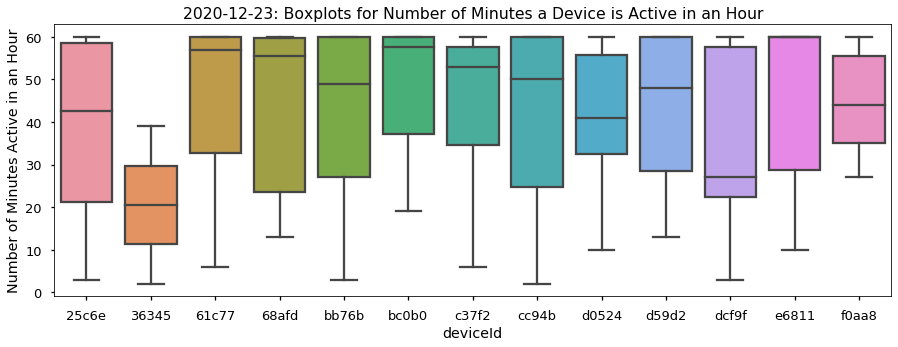

          count       mean        std   min    25%   50%    75%   max
deviceId                                                             
25c6e      17.0  36.176471  18.732443   7.0  21.00  40.0  53.00  60.0
61c77      18.0  27.833333  16.259839   2.0  16.00  25.5  39.75  60.0
68afd      19.0  43.684211  20.210153   3.0  39.00  55.0  59.00  60.0
bb76b      18.0  37.833333  19.008512   6.0  22.75  36.5  59.50  60.0
bc0b0      20.0  43.350000  18.336834   3.0  24.50  50.0  60.00  60.0
c37f2      18.0  40.222222  17.933064  11.0  23.00  41.5  59.50  60.0
cc94b      17.0  38.470588  19.316824   3.0  23.00  39.0  60.00  60.0
d0524      17.0  43.058824  18.294366   1.0  34.00  47.0  60.00  60.0
d59d2      19.0  43.947368  21.844078   1.0  32.00  60.0  60.00  60.0
dcf9f      15.0  31.266667  20.537306   1.0  13.50  29.0  51.50  60.0
e6811      21.0  50.761905  18.492985   4.0  57.00  60.0  60.00  60.0


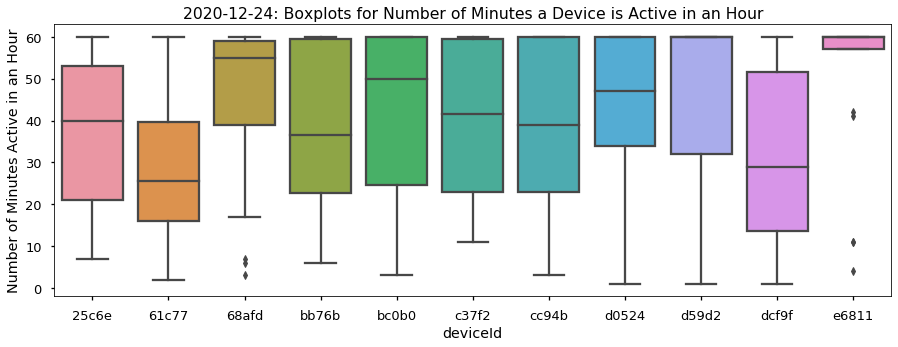

          count       mean        std   min    25%   50%   75%   max
deviceId                                                            
25c6e      19.0  51.368421  16.543581   5.0  55.00  60.0  60.0  60.0
61c77      18.0  42.166667  15.941990  20.0  26.00  41.5  58.5  60.0
68afd      19.0  50.473684  16.631190   9.0  52.50  60.0  60.0  60.0
bb76b      17.0  33.705882  22.418644   1.0  15.00  36.0  60.0  60.0
bc0b0      15.0  41.333333  19.841035   6.0  30.00  45.0  59.5  60.0
c37f2      20.0  44.050000  17.620189  10.0  31.25  49.0  60.0  60.0
cc94b      13.0  32.846154  19.535635   3.0  20.00  31.0  48.0  60.0
d0524      15.0  37.866667  18.905278   1.0  28.00  37.0  53.5  60.0
d59d2      19.0  38.578947  15.983727   6.0  30.00  37.0  52.0  60.0
dcf9f      11.0  14.636364   7.877471   2.0   9.00  16.0  20.0  26.0
e6811      21.0  52.904762  14.892632  11.0  59.00  60.0  60.0  60.0


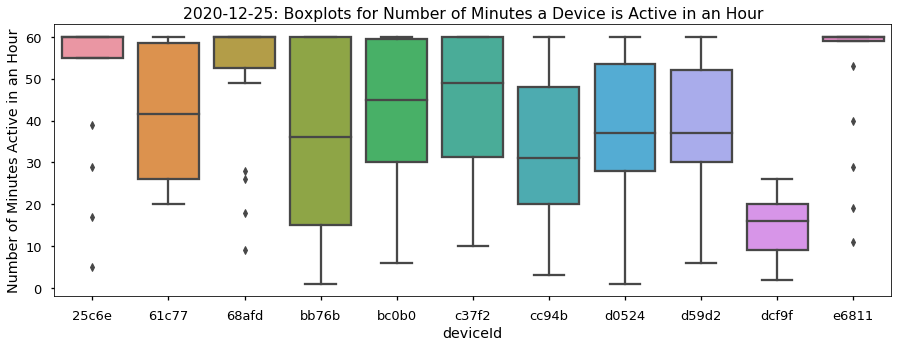

          count       mean        std   min    25%   50%    75%   max
deviceId                                                             
25c6e      15.0  46.133333  15.555737  19.0  31.50  52.0  60.00  60.0
61c77      17.0  42.941176  18.548823   3.0  30.00  43.0  60.00  60.0
68afd      18.0  43.055556  18.076544   2.0  38.50  46.5  58.00  60.0
bb76b      21.0  40.523810  19.158860   3.0  29.00  41.0  60.00  60.0
bc0b0      19.0  41.052632  14.381600  10.0  30.00  38.0  52.50  60.0
c37f2      19.0  40.263158  19.223371   6.0  26.50  43.0  60.00  60.0
cc94b      16.0  41.312500  22.808533   6.0  22.00  55.5  60.00  60.0
d0524      16.0  40.875000  18.503603   5.0  30.75  44.0  56.25  60.0
d59d2      19.0  35.894737  22.444734   4.0  17.00  42.0  59.00  60.0
dcf9f      17.0  25.941176  15.809295   6.0  11.00  28.0  37.00  60.0
e6811      20.0  54.300000  11.828156  27.0  59.75  60.0  60.00  60.0


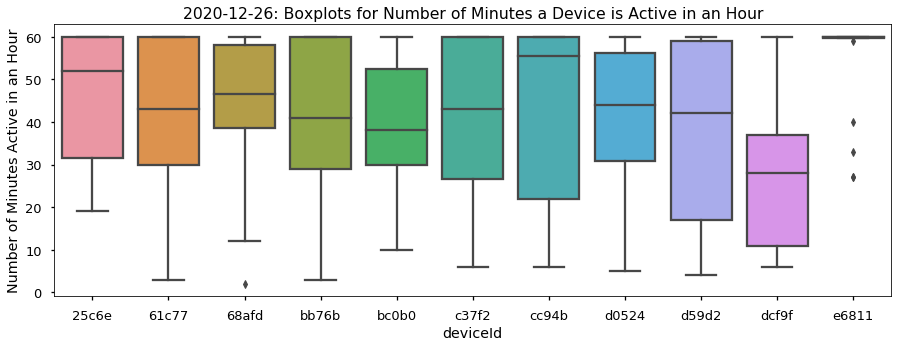

          count       mean        std   min    25%   50%    75%   max
deviceId                                                             
25c6e      21.0  50.952381  18.440380   5.0  60.00  60.0  60.00  60.0
61c77      16.0  40.687500  20.761242   8.0  21.75  48.5  60.00  60.0
68afd      24.0  56.875000   6.536270  35.0  57.00  59.5  60.00  60.0
bb76b      24.0  48.916667  17.822596   2.0  42.25  60.0  60.00  60.0
bc0b0      19.0  35.789474  20.980358   3.0  20.50  33.0  60.00  60.0
c37f2      23.0  50.173913  11.215461  25.0  41.00  55.0  60.00  60.0
cc94b      19.0  36.052632  23.241423   2.0  15.50  43.0  60.00  60.0
d0524      16.0  39.125000  18.362552   7.0  30.75  40.5  56.25  60.0
d59d2      20.0  36.350000  19.129132   7.0  17.00  36.5  53.50  60.0
dcf9f      12.0  29.500000  18.768930   5.0  15.75  24.5  44.75  58.0
e6811      14.0  40.071429  27.457560   2.0   6.00  60.0  60.00  60.0


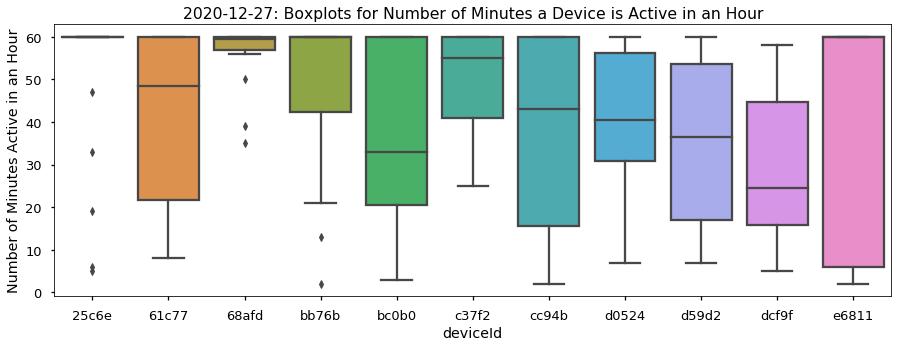

          count       mean        std   min   25%   50%   75%   max
deviceId                                                           
25c6e       3.0  37.000000  20.663978  20.0  25.5  31.0  45.5  60.0
61c77      15.0  37.133333  20.625458   6.0  21.0  34.0  60.0  60.0
68afd      15.0  46.866667  17.695305   7.0  32.0  58.0  60.0  60.0
bb76b      23.0  41.608696  19.823629   2.0  26.5  48.0  60.0  60.0
bc0b0      19.0  45.631579  19.166552   4.0  33.0  59.0  60.0  60.0
c37f2      20.0  47.000000  16.836677   1.0  38.0  56.5  60.0  60.0
cc94b      15.0  43.733333  17.248050  14.0  26.0  51.0  60.0  60.0
d0524      13.0  44.307692  16.347195   5.0  35.0  50.0  58.0  60.0
d59d2      22.0  40.590909  19.953897   2.0  28.0  47.0  60.0  60.0
dcf9f      11.0  30.454545  22.761211   1.0  11.5  27.0  52.5  60.0
e6811      19.0  52.842105  14.701713   5.0  53.5  60.0  60.0  60.0


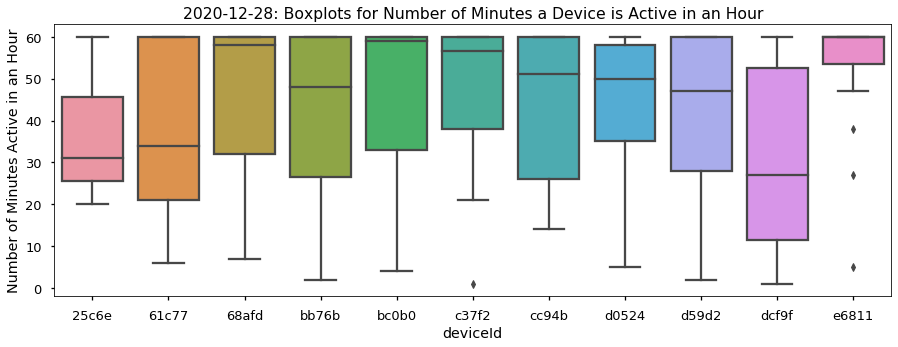

          count       mean        std   min    25%   50%    75%   max
deviceId                                                             
25c6e       3.0  10.000000   8.000000   2.0   6.00  10.0  14.00  18.0
36345      10.0  44.500000  17.964471   6.0  36.50  49.0  59.00  60.0
61c77      19.0  40.578947  20.862821   2.0  27.50  45.0  59.50  60.0
68afd      20.0  50.750000  13.575811  14.0  49.25  56.0  60.00  60.0
bb76b      22.0  45.954545  17.857844   4.0  33.25  54.0  60.00  60.0
bc0b0      20.0  38.850000  22.103286   2.0  17.75  43.0  60.00  60.0
c37f2      20.0  46.950000  15.370769  18.0  32.50  56.5  60.00  60.0
cc94b      18.0  39.000000  22.457804   4.0  14.50  45.0  60.00  60.0
d0524      19.0  38.473684  20.328875   2.0  21.00  43.0  58.00  60.0
d59d2       1.0  21.000000        NaN  21.0  21.00  21.0  21.00  21.0
dcf9f      14.0  35.928571  23.345117   4.0  11.75  46.5  58.25  60.0
e6811      10.0  40.100000  21.880737   7.0  25.00  44.0  60.00  60.0
f0aa8      20.0  57.

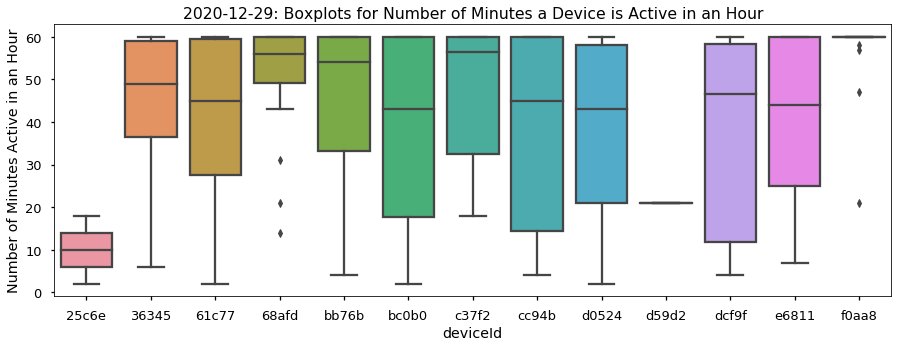

          count       mean        std   min    25%   50%   75%   max
deviceId                                                            
61c77      21.0  45.095238  16.837175   6.0  34.00  54.0  60.0  60.0
68afd      20.0  42.750000  17.444272  11.0  33.25  46.5  60.0  60.0
bb76b      13.0  39.153846  23.129513   2.0  24.00  49.0  60.0  60.0
bc0b0      23.0  41.869565  23.118871   2.0  22.00  58.0  60.0  60.0
c37f2      21.0  43.142857  20.479955   1.0  27.00  56.0  60.0  60.0
cc94b      17.0  35.882353  17.909084   9.0  22.00  30.0  52.0  60.0
d0524      18.0  44.277778  16.676174  17.0  32.00  50.0  60.0  60.0
d59d2      13.0  41.769231  20.253205   7.0  25.00  49.0  60.0  60.0
dcf9f      12.0  28.666667  18.326996   3.0  13.75  26.0  43.5  57.0
e6811      13.0  51.846154  14.369216  13.0  49.00  60.0  60.0  60.0
f0aa8      22.0  56.863636   8.166689  28.0  59.25  60.0  60.0  60.0


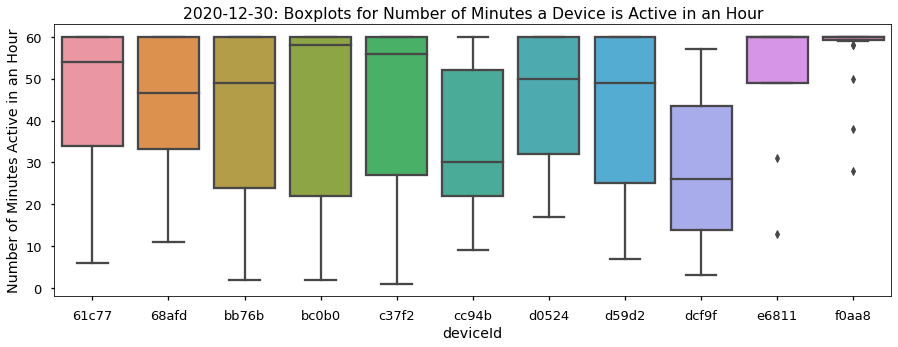

          count       mean        std   min    25%   50%   75%   max
deviceId                                                            
25c6e      19.0  43.842105  17.976105   4.0  35.00  49.0  60.0  60.0
36345      19.0  38.578947  18.959945   7.0  27.00  40.0  58.0  60.0
61c77      23.0  46.782609  17.834992   7.0  39.00  55.0  60.0  60.0
68afd      24.0  52.708333   9.751161  31.0  47.75  59.0  60.0  60.0
bb76b      23.0  39.695652  18.914724   8.0  22.50  43.0  60.0  60.0
bc0b0      22.0  47.000000  14.592888  17.0  36.75  51.0  60.0  60.0
c37f2      21.0  49.333333  14.924253  16.0  41.00  60.0  60.0  60.0
cc94b      19.0  37.368421  20.720925   2.0  16.50  40.0  60.0  60.0
d0524      15.0  37.200000  22.149492   1.0  24.50  49.0  52.5  60.0
d59d2       1.0  27.000000        NaN  27.0  27.00  27.0  27.0  27.0
dcf9f      12.0  33.500000  19.736906  10.0  14.75  33.0  50.5  60.0
e6811      21.0  42.428571  21.618445   2.0  24.00  52.0  60.0  60.0
f0aa8      20.0  55.050000  13.971

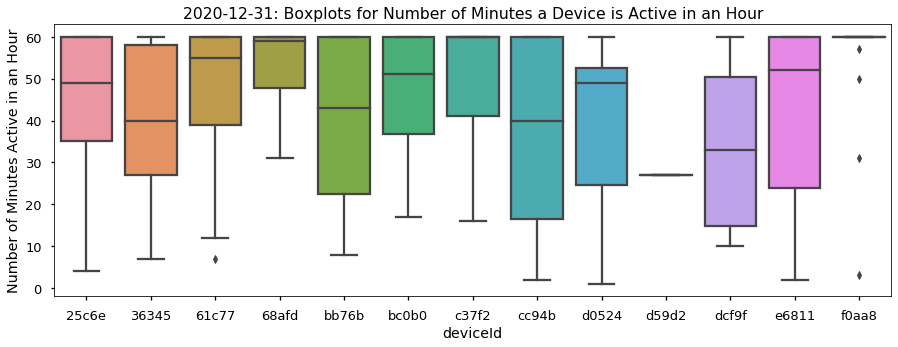

          count       mean        std   min    25%   50%    75%   max
deviceId                                                             
36345      14.0  44.071429  20.458078   4.0  25.50  59.5  60.00  60.0
61c77      11.0  37.181818  23.163843   7.0  14.50  43.0  60.00  60.0
68afd      16.0  43.562500  18.359262   3.0  31.25  49.5  60.00  60.0
bb76b      22.0  48.863636  15.639679  20.0  37.50  60.0  60.00  60.0
c37f2      19.0  42.052632  15.770837   8.0  31.00  45.0  55.50  60.0
cc94b      18.0  33.000000  19.973512   6.0  16.75  28.0  54.50  60.0
d0524      15.0  39.533333  15.273070   4.0  32.50  40.0  50.00  60.0
d59d2      19.0  34.736842  21.436838   3.0  14.50  33.0  60.00  60.0
dcf9f      10.0  35.100000  20.501761   3.0  21.00  34.5  55.50  60.0
e6811      14.0  30.857143  21.454270   3.0  12.00  29.0  48.25  60.0
f0aa8      22.0  48.045455  15.182939   9.0  40.50  54.0  60.00  60.0


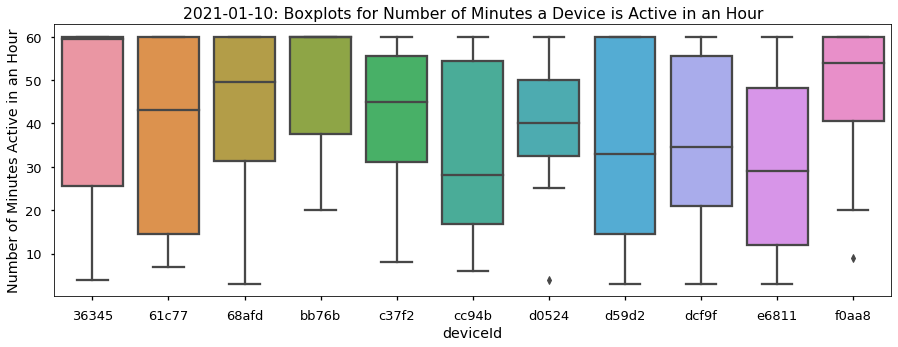

          count       mean        std   min    25%   50%    75%   max
deviceId                                                             
25c6e       1.0   9.000000        NaN   9.0   9.00   9.0   9.00   9.0
61c77      21.0  42.333333  18.317569   8.0  27.00  49.0  60.00  60.0
68afd      10.0  38.800000  20.422210   5.0  26.25  38.5  59.50  60.0
bb76b      20.0  45.850000  19.197793   4.0  34.75  60.0  60.00  60.0
c37f2      24.0  52.625000  12.520635  18.0  50.50  59.5  60.00  60.0
cc94b      24.0  36.041667  20.693370   7.0  16.50  40.5  60.00  60.0
d0524      19.0  37.894737  17.791680   1.0  30.50  36.0  54.00  60.0
d59d2      20.0  43.450000  18.969435   6.0  29.50  52.5  60.00  60.0
dcf9f      14.0  37.857143  21.696711   1.0  21.25  45.0  56.25  60.0
e6811      13.0  39.615385  20.990230  11.0  17.00  52.0  60.00  60.0
f0aa8      24.0  48.541667  12.870523  14.0  40.50  53.0  60.00  60.0


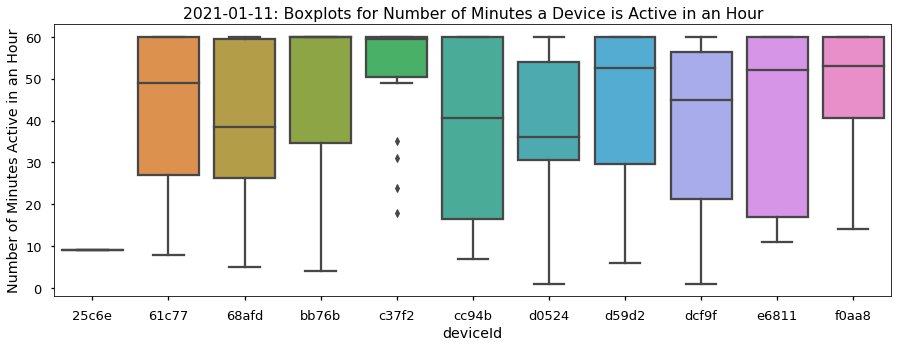

          count       mean        std   min    25%   50%    75%   max
deviceId                                                             
25c6e       1.0   8.000000        NaN   8.0   8.00   8.0   8.00   8.0
36345       4.0  44.000000  16.990193  26.0  31.25  45.5  58.25  59.0
61c77      11.0  38.818182  20.291960   1.0  37.00  41.0  52.00  60.0
68afd      21.0  53.523810  14.427817   7.0  58.00  60.0  60.00  60.0
bb76b      16.0  51.562500  13.326509  24.0  46.25  60.0  60.00  60.0
c37f2      22.0  52.636364  14.059552   8.0  56.00  59.0  60.00  60.0
cc94b      19.0  42.473684  20.576061   2.0  22.50  52.0  60.00  60.0
d0524      17.0  33.764706  18.304813   8.0  18.00  31.0  48.00  60.0
d59d2      19.0  38.368421  19.864011   8.0  20.50  38.0  60.00  60.0
dcf9f      16.0  32.062500  20.853357   2.0  13.00  33.5  50.00  60.0
e6811      22.0  42.363636  22.944126   5.0  22.75  60.0  60.00  60.0
f0aa8      22.0  55.590909  11.496000  10.0  59.25  60.0  60.00  60.0


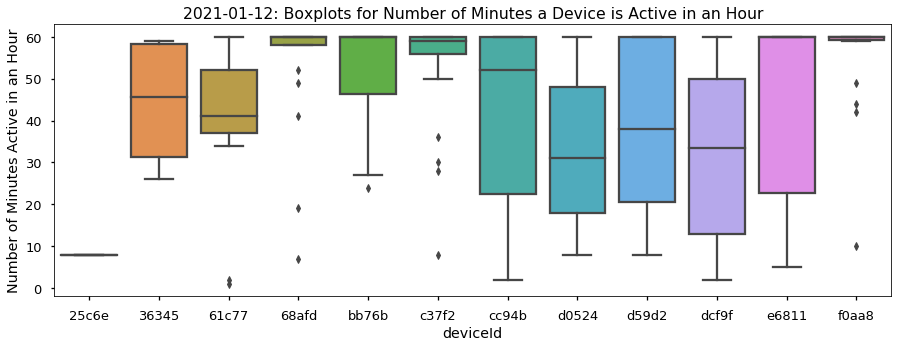

          count       mean        std   min    25%   50%    75%   max
deviceId                                                             
25c6e       4.0  28.750000  26.399179   4.0   8.50  25.5  45.75  60.0
36345      20.0  48.250000  18.580904   3.0  44.00  58.5  60.00  60.0
61c77      14.0  33.142857  20.523372   6.0  12.75  38.0  49.25  60.0
68afd      19.0  47.263158  21.620058   1.0  52.00  58.0  60.00  60.0
bb76b      22.0  41.045455  20.603923   7.0  25.50  48.0  60.00  60.0
bc0b0      20.0  39.200000  21.147602   2.0  20.75  49.5  59.25  60.0
c37f2      22.0  50.681818  18.140684   1.0  50.25  59.0  60.00  60.0
cc94b      17.0  36.058824  21.217536   4.0  22.00  37.0  60.00  60.0
d0524      18.0  39.555556  20.012414   5.0  24.75  44.5  60.00  60.0
d59d2      22.0  42.000000  18.544669  11.0  30.50  45.5  60.00  60.0
dcf9f      19.0  37.894737  20.736159   4.0  20.00  42.0  57.50  60.0
e6811      18.0  49.666667  19.057189   5.0  45.75  60.0  60.00  60.0
f0aa8      24.0  57.

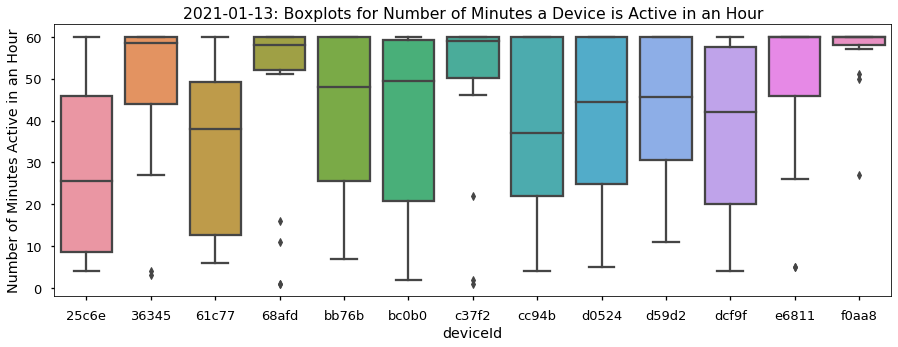

          count       mean        std   min    25%   50%    75%   max
deviceId                                                             
25c6e       5.0  15.200000  10.848963   6.0   8.00   9.0  22.00  31.0
36345      23.0  37.260870  22.571538   1.0  20.50  44.0  57.50  60.0
61c77      14.0  44.142857  18.016476   5.0  30.00  49.5  59.00  60.0
68afd      18.0  41.277778  23.491690   2.0  17.00  56.0  59.75  60.0
bb76b      22.0  44.727273  20.867340   3.0  27.75  60.0  60.00  60.0
bc0b0      19.0  32.210526  17.768821   1.0  23.00  28.0  47.50  60.0
c37f2      18.0  45.000000  18.149704   6.0  37.00  53.0  60.00  60.0
cc94b      19.0  40.789474  21.472409   3.0  26.50  50.0  60.00  60.0
d0524      16.0  42.937500  18.189626   7.0  29.75  48.0  60.00  60.0
d59d2      20.0  42.100000  19.531082   5.0  22.50  48.5  60.00  60.0
dcf9f      13.0  29.692308  21.108389   9.0  14.00  17.0  56.00  60.0
e6811       8.0  40.500000  26.087764   2.0  14.00  58.0  60.00  60.0
f0aa8      22.0  50.

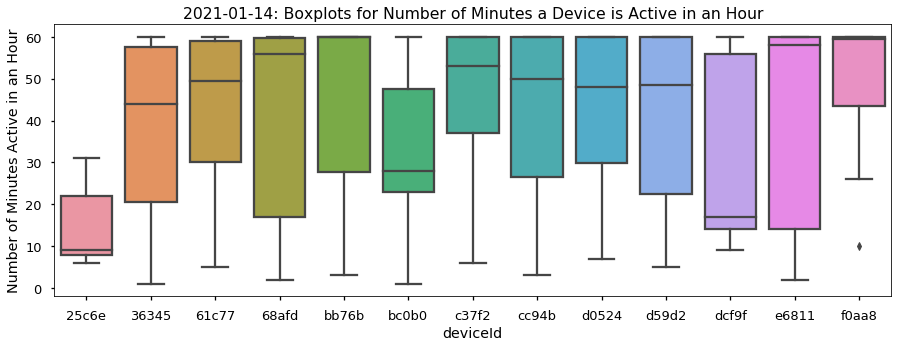

          count       mean        std   min    25%   50%   75%   max
deviceId                                                            
36345      24.0  40.458333  19.094682  10.0  23.75  42.5  60.0  60.0
61c77      16.0  52.437500  14.123119   8.0  50.75  59.5  60.0  60.0
68afd      19.0  51.526316  10.951248  30.0  46.50  58.0  60.0  60.0
bc0b0      24.0  42.791667  19.314287   7.0  26.25  51.5  60.0  60.0
c37f2      18.0  42.666667  20.818544   2.0  25.50  53.5  60.0  60.0
cc94b      13.0  32.307692  24.091439   3.0   6.00  40.0  59.0  60.0
d0524      18.0  36.000000  20.338315   4.0  20.00  38.0  55.5  60.0
dcf9f      12.0  31.333333  25.057510   2.0  11.00  23.0  60.0  60.0
e6811      12.0  48.000000  18.374884   4.0  35.50  60.0  60.0  60.0
f0aa8      24.0  59.250000   3.260435  44.0  60.00  60.0  60.0  60.0


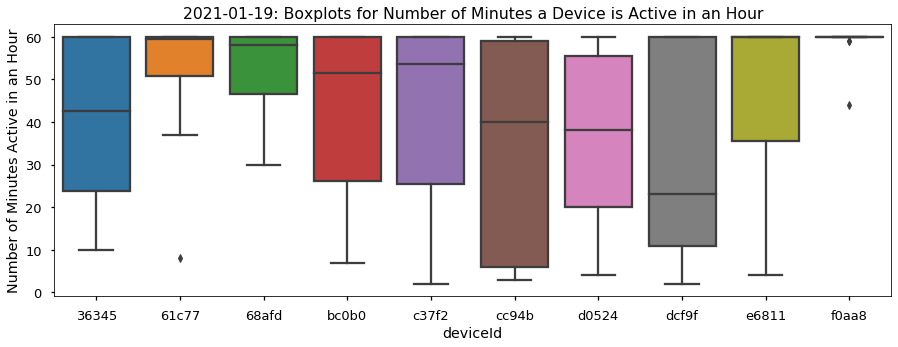

          count       mean        std   min    25%   50%    75%   max
deviceId                                                             
36345      24.0  38.666667  17.407311   1.0  27.75  40.0  54.75  60.0
61c77      17.0  33.352941  16.278595   7.0  20.00  37.0  44.00  60.0
68afd      20.0  51.550000  11.353066  21.0  49.00  56.5  60.00  60.0
bb76b      21.0  49.047619  19.327380   5.0  44.00  60.0  60.00  60.0
bc0b0      21.0  42.047619  18.580840   5.0  27.00  49.0  60.00  60.0
c37f2      18.0  40.833333  20.771162   4.0  23.25  46.5  60.00  60.0
cc94b      16.0  28.875000  22.788521   4.0   9.00  21.0  60.00  60.0
d0524      18.0  37.722222  18.898508   8.0  21.25  39.0  58.00  60.0
dcf9f       5.0  25.000000  21.656408   2.0  14.00  24.0  25.00  60.0
e6811      18.0  48.444444  19.632573   7.0  39.00  60.0  60.00  60.0
f0aa8      19.0  57.526316   5.511286  41.0  59.00  60.0  60.00  60.0


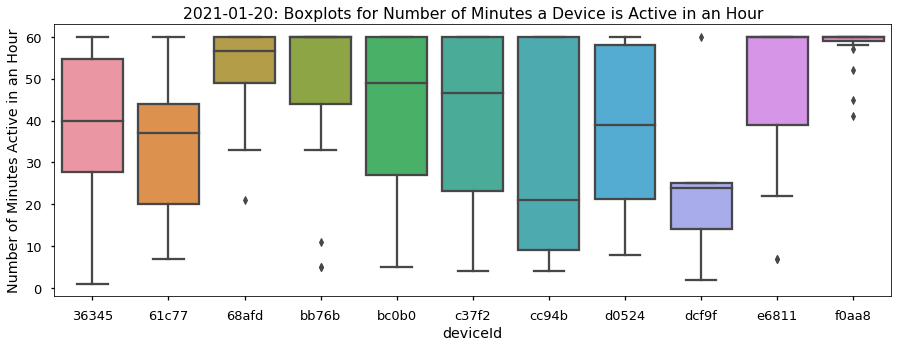

          count       mean        std   min    25%   50%    75%   max
deviceId                                                             
36345      14.0  34.357143  14.291510  11.0  27.25  31.0  39.50  60.0
61c77      16.0  41.187500  20.166701   4.0  24.25  48.5  59.25  60.0
68afd       7.0  48.571429  17.961599  20.0  40.00  60.0  60.00  60.0
bb76b      22.0  49.090909  19.644238   9.0  53.50  60.0  60.00  60.0
bc0b0      18.0  42.277778  20.772735   3.0  22.75  54.0  60.00  60.0
c37f2      19.0  51.368421  14.697734  17.0  52.00  60.0  60.00  60.0
cc94b      17.0  36.470588  19.455454   6.0  19.00  39.0  54.00  60.0
d0524      16.0  35.312500  21.231168   8.0  13.75  37.5  58.25  60.0
d59d2      22.0  46.181818  18.360507   8.0  36.50  55.5  60.00  60.0
e6811      20.0  50.050000  17.721456   7.0  49.50  60.0  60.00  60.0
f0aa8      22.0  58.409091   4.414900  42.0  60.00  60.0  60.00  60.0


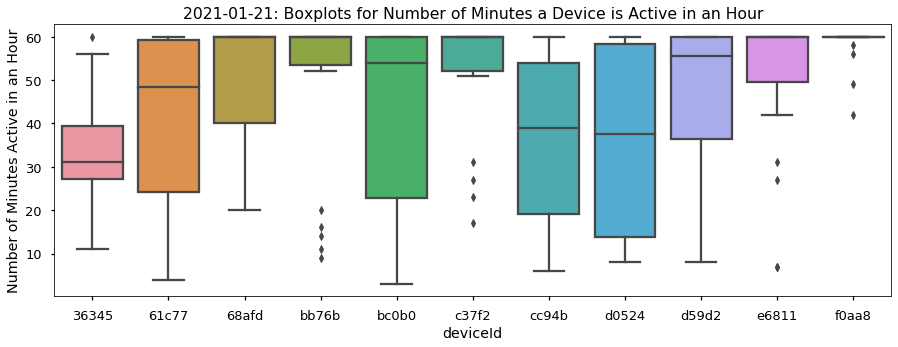

          count       mean        std   min    25%   50%    75%   max
deviceId                                                             
36345      21.0  42.142857  18.639436  10.0  26.00  49.0  60.00  60.0
61c77      21.0  39.333333  24.162643   1.0  12.00  53.0  60.00  60.0
68afd      16.0  50.812500  12.796972  26.0  43.25  59.0  60.00  60.0
bb76b      13.0  37.153846  18.968598   6.0  22.00  43.0  52.00  60.0
bc0b0      24.0  43.416667  22.175028   1.0  26.50  58.5  60.00  60.0
c37f2      22.0  42.454545  20.465365   5.0  26.75  52.5  60.00  60.0
cc94b      17.0  40.647059  19.710217   2.0  24.00  44.0  59.00  60.0
d0524      18.0  31.222222  16.955150   2.0  20.00  29.5  45.25  60.0
d59d2      20.0  40.050000  19.546099   9.0  21.00  46.0  60.00  60.0
e6811      13.0  57.692308   4.973004  43.0  58.00  60.0  60.00  60.0
f0aa8      21.0  53.666667  14.454526   6.0  60.00  60.0  60.00  60.0


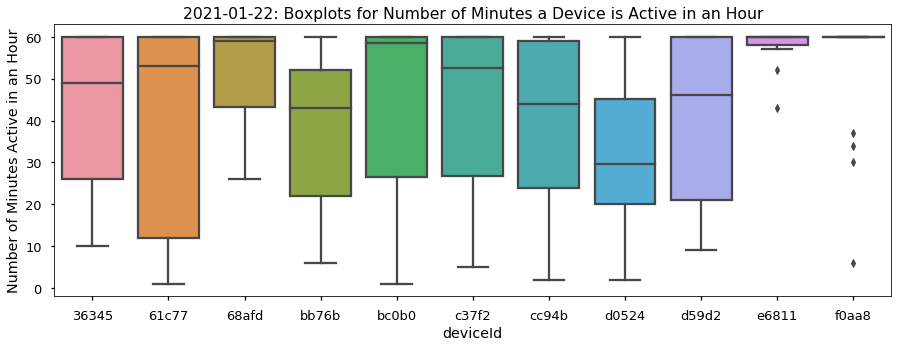

          count       mean        std   min    25%   50%    75%   max
deviceId                                                             
25c6e       2.0   4.000000   2.828427   2.0   3.00   4.0   5.00   6.0
36345      16.0  44.687500  20.476714   3.0  32.00  53.0  60.00  60.0
61c77      13.0  38.923077  20.089224   8.0  23.00  37.0  59.00  60.0
68afd      24.0  53.666667  10.809282  24.0  50.00  59.5  60.00  60.0
bb76b      23.0  45.260870  16.276635  17.0  30.00  51.0  60.00  60.0
c37f2      24.0  51.166667  15.602861   9.0  53.50  58.0  60.00  60.0
cc94b      19.0  36.736842  20.978407   2.0  20.00  37.0  59.50  60.0
d0524      18.0  30.611111  18.407604   2.0  18.00  33.0  45.25  60.0
d59d2      18.0  41.111111  18.717368   3.0  36.00  44.5  59.25  60.0
dcf9f      16.0  27.125000  20.096020   2.0   9.75  21.5  43.50  60.0
e6811      16.0  35.937500  21.760725   5.0  21.00  31.0  59.25  60.0
f0aa8      23.0  49.304348  18.609467   2.0  47.00  59.0  60.00  60.0


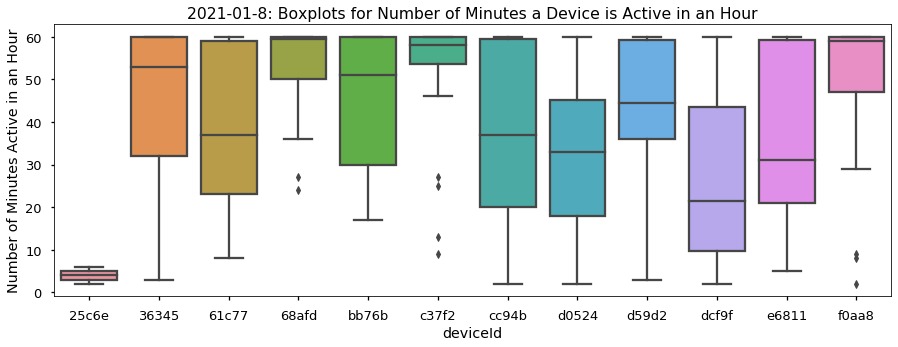

          count       mean        std  min    25%   50%    75%   max
deviceId                                                            
25c6e       1.0   4.000000        NaN  4.0   4.00   4.0   4.00   4.0
36345      22.0  41.318182  19.664777  4.0  30.25  44.5  60.00  60.0
61c77       5.0  19.000000  14.983324  4.0   6.00  17.0  29.00  39.0
68afd      21.0  50.142857  17.547894  1.0  51.00  60.0  60.00  60.0
bb76b      23.0  46.913043  18.846058  6.0  31.50  60.0  60.00  60.0
c37f2      22.0  42.227273  19.537344  3.0  25.00  50.5  60.00  60.0
cc94b      15.0  38.733333  19.199950  6.0  27.50  41.0  60.00  60.0
d0524      17.0  38.941176  16.764809  5.0  29.00  39.0  51.00  60.0
d59d2      20.0  35.600000  22.144026  1.0  16.75  39.5  59.25  60.0
dcf9f      19.0  31.000000  19.793377  4.0  11.50  29.0  48.50  60.0
e6811      16.0  41.250000  20.335519  5.0  24.75  49.0  60.00  60.0
f0aa8      21.0  41.380952  16.286424  7.0  33.00  44.0  58.00  60.0


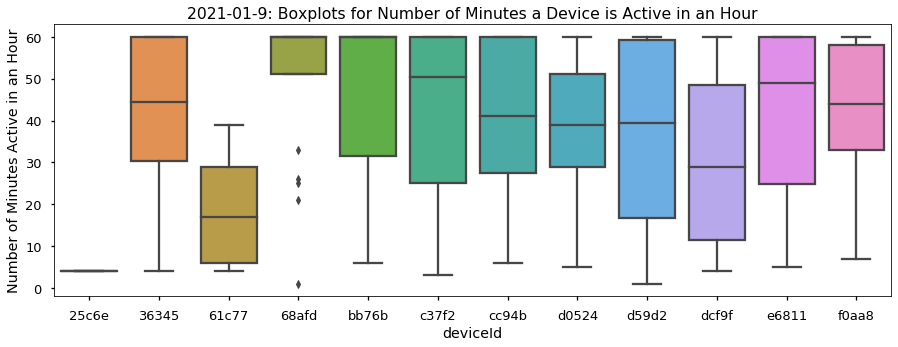

In [8]:
# it will plot for sd_2
result = plot_plotwise_for_all_dates_ds2()

In [2]:
plot_plotwise("ds_1",23,28)

NameError: name 'read_raw' is not defined

In [ ]:
sub.describe()

          count       mean        std   min    25%   50%    75%   max
deviceId                                                             
25c6e      18.0  37.000000  20.676784   3.0  21.25  42.5  58.50  60.0
36345       2.0  20.500000  26.162951   2.0  11.25  20.5  29.75  39.0
61c77      18.0  45.055556  19.702112   6.0  32.75  57.0  60.00  60.0
68afd      22.0  44.136364  18.504299  13.0  23.50  55.5  59.75  60.0
bb76b      17.0  41.529412  19.134777   3.0  27.00  49.0  60.00  60.0
bc0b0      20.0  49.450000  13.268383  19.0  37.25  57.5  60.00  60.0
c37f2      23.0  44.956522  16.720913   6.0  34.50  53.0  57.50  60.0
cc94b      20.0  42.550000  18.774212   2.0  24.75  50.0  60.00  60.0
d0524      14.0  40.785714  15.812257  10.0  32.50  41.0  55.75  60.0
d59d2      18.0  43.277778  17.357167  13.0  28.50  48.0  60.00  60.0
dcf9f      11.0  36.909091  21.234192   3.0  22.50  27.0  57.50  60.0
e6811       8.0  44.625000  22.341106  10.0  28.75  60.0  60.00  60.0
f0aa8       7.0  44.

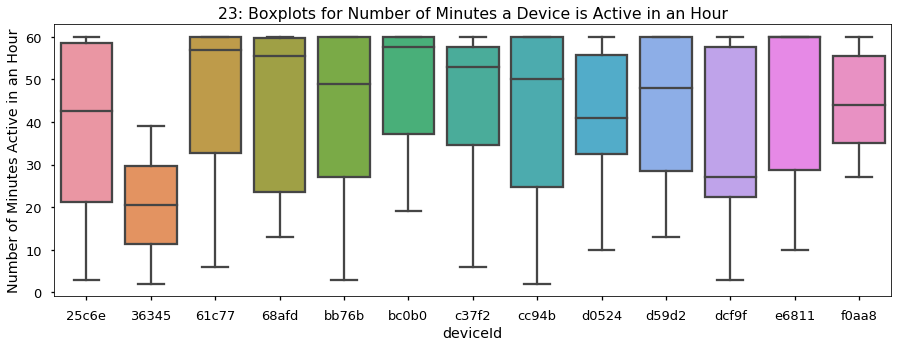

          count       mean        std   min    25%   50%    75%   max
deviceId                                                             
25c6e      17.0  36.176471  18.732443   7.0  21.00  40.0  53.00  60.0
61c77      18.0  27.833333  16.259839   2.0  16.00  25.5  39.75  60.0
68afd      19.0  43.684211  20.210153   3.0  39.00  55.0  59.00  60.0
bb76b      18.0  37.833333  19.008512   6.0  22.75  36.5  59.50  60.0
bc0b0      20.0  43.350000  18.336834   3.0  24.50  50.0  60.00  60.0
c37f2      18.0  40.222222  17.933064  11.0  23.00  41.5  59.50  60.0
cc94b      17.0  38.470588  19.316824   3.0  23.00  39.0  60.00  60.0
d0524      17.0  43.058824  18.294366   1.0  34.00  47.0  60.00  60.0
d59d2      19.0  43.947368  21.844078   1.0  32.00  60.0  60.00  60.0
dcf9f      15.0  31.266667  20.537306   1.0  13.50  29.0  51.50  60.0
e6811      21.0  50.761905  18.492985   4.0  57.00  60.0  60.00  60.0


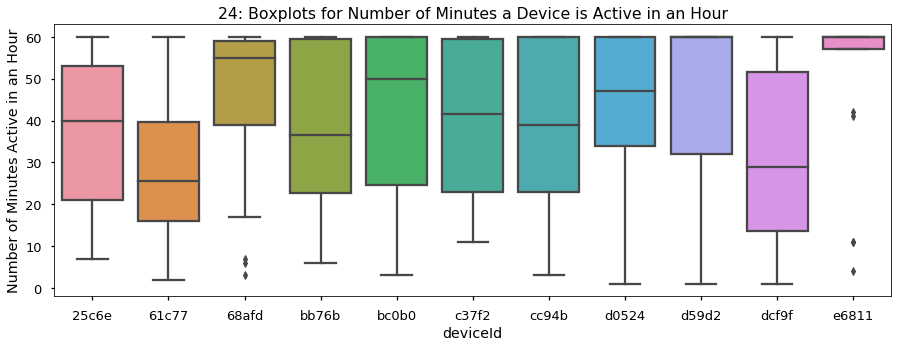

          count       mean        std   min    25%   50%   75%   max
deviceId                                                            
25c6e      19.0  51.368421  16.543581   5.0  55.00  60.0  60.0  60.0
61c77      18.0  42.166667  15.941990  20.0  26.00  41.5  58.5  60.0
68afd      19.0  50.473684  16.631190   9.0  52.50  60.0  60.0  60.0
bb76b      17.0  33.705882  22.418644   1.0  15.00  36.0  60.0  60.0
bc0b0      15.0  41.333333  19.841035   6.0  30.00  45.0  59.5  60.0
c37f2      20.0  44.050000  17.620189  10.0  31.25  49.0  60.0  60.0
cc94b      13.0  32.846154  19.535635   3.0  20.00  31.0  48.0  60.0
d0524      15.0  37.866667  18.905278   1.0  28.00  37.0  53.5  60.0
d59d2      19.0  38.578947  15.983727   6.0  30.00  37.0  52.0  60.0
dcf9f      11.0  14.636364   7.877471   2.0   9.00  16.0  20.0  26.0
e6811      21.0  52.904762  14.892632  11.0  59.00  60.0  60.0  60.0


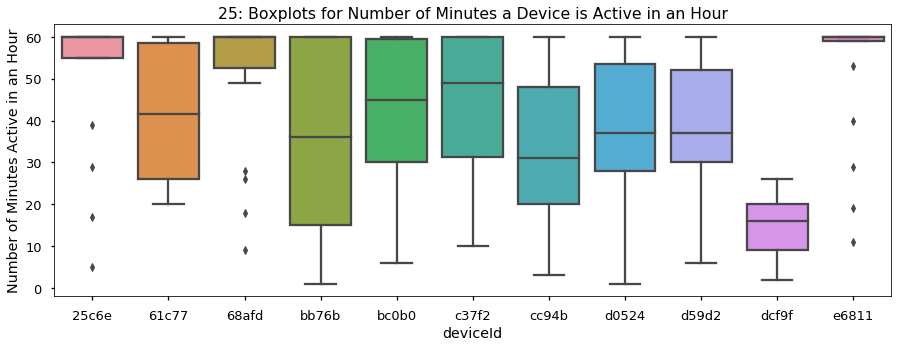

In [4]:
result = plot_plotwise("ds_2",23,25)

In [9]:
#stats of ds_2
print(result[0])
dist_medians = []
dist_75 = []
dist_25 = []
for df in result:
#     print(df.size())
    for i in range(len(df)):
#         print(df.iloc[i]['50%'])
        dist_medians.append(df.iloc[i]['50%'])
        dist_75.append(df.iloc[i]['75%'])
        dist_25.append(df.iloc[i]['25%'])
#     print('dome')

print(dist_medians)
stats =  {'medians': dist_medians, 
        '25th': dist_25, '75th' : dist_75}  
stats = pd.DataFrame.from_dict(stats) 
print(stats.describe())


          count       mean        std   min    25%   50%    75%   max
deviceId                                                             
25c6e      18.0  37.000000  20.676784   3.0  21.25  42.5  58.50  60.0
36345       2.0  20.500000  26.162951   2.0  11.25  20.5  29.75  39.0
61c77      18.0  45.055556  19.702112   6.0  32.75  57.0  60.00  60.0
68afd      22.0  44.136364  18.504299  13.0  23.50  55.5  59.75  60.0
bb76b      17.0  41.529412  19.134777   3.0  27.00  49.0  60.00  60.0
bc0b0      20.0  49.450000  13.268383  19.0  37.25  57.5  60.00  60.0
c37f2      23.0  44.956522  16.720913   6.0  34.50  53.0  57.50  60.0
cc94b      20.0  42.550000  18.774212   2.0  24.75  50.0  60.00  60.0
d0524      14.0  40.785714  15.812257  10.0  32.50  41.0  55.75  60.0
d59d2      18.0  43.277778  17.357167  13.0  28.50  48.0  60.00  60.0
dcf9f      11.0  36.909091  21.234192   3.0  22.50  27.0  57.50  60.0
e6811       8.0  44.625000  22.341106  10.0  28.75  60.0  60.00  60.0
f0aa8       7.0  44.

In [ ]:
plot_plotwise("ds_1")

2) Distribution of Number of Minutes each Device was Active in an Hour

In [ ]:
plot_plotwise("ds_2")

3) Aggregated Distribution of Number of Recordings per Minute

In [ ]:
plot_plotwise("ds_3")

4) Aggregated Total Number of Readings per Minute

In [ ]:
# plot_plotwise("ds_4")

5) Number of Hours each Device was Active

In [ ]:
plot_plotwise("ds_5")

#### Spatial Metrics

1. Proportion of Points with Invalid Coordinates (lat or long <=1)

In [ ]:
# plot_plotwise("s_1")

#### Location and Time Metric
1. Distribution of Regions with Hours

In [ ]:
plot_plotwise("l_t")

#### PM Metric
1) Intra-Sensor Distribution of PM 2.5 Values at Depot

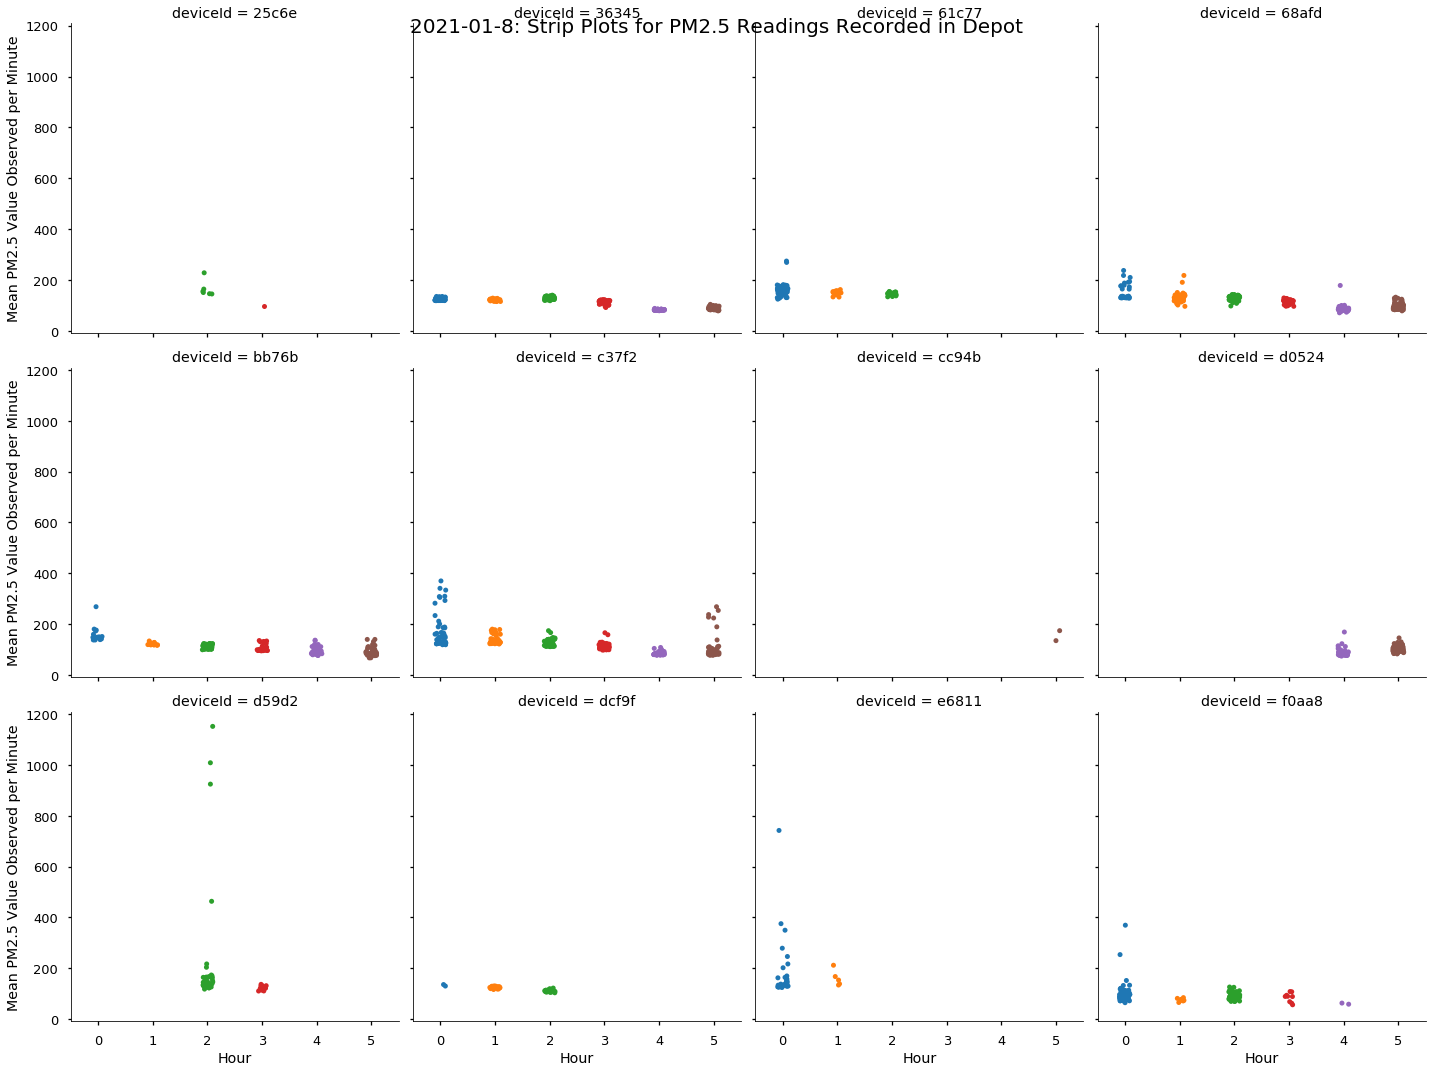

In [48]:
plot_plotwise_for_all_dates_PM25('2021-01-8',"pm_1")

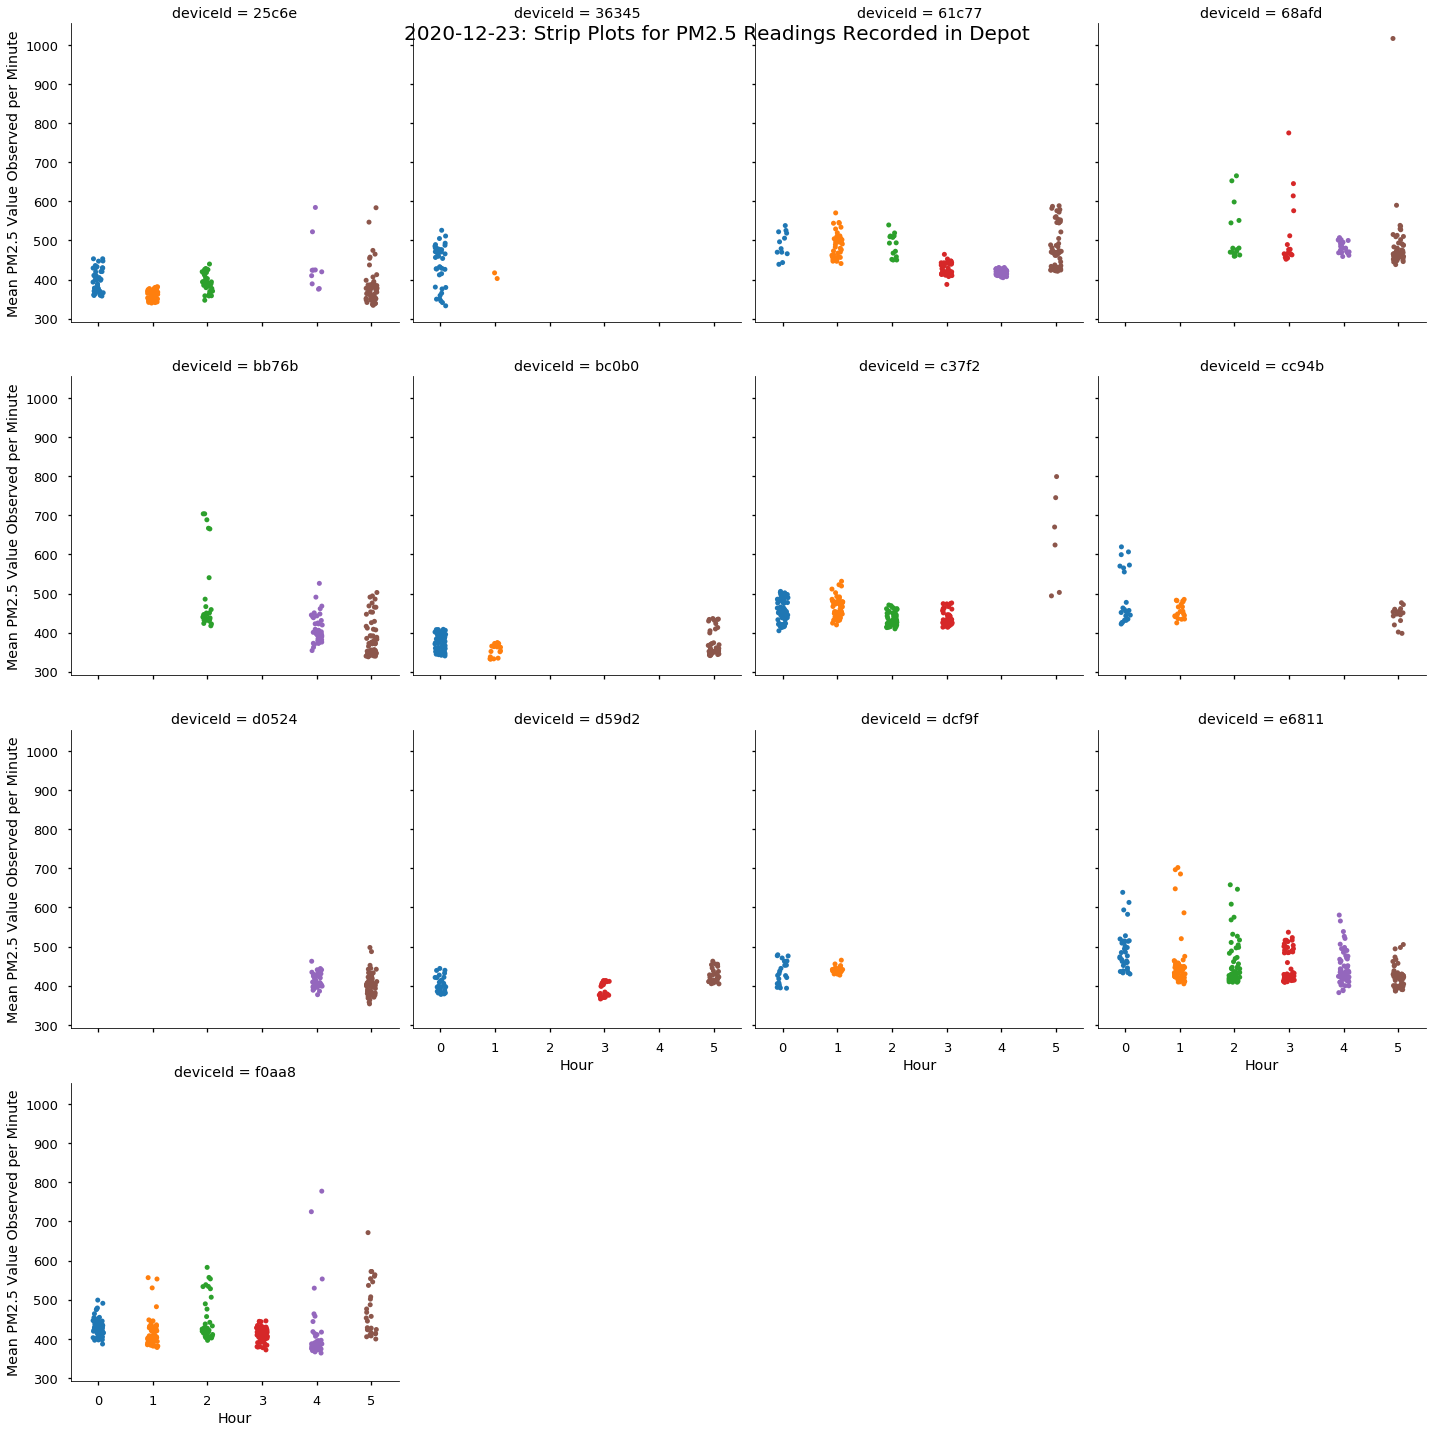

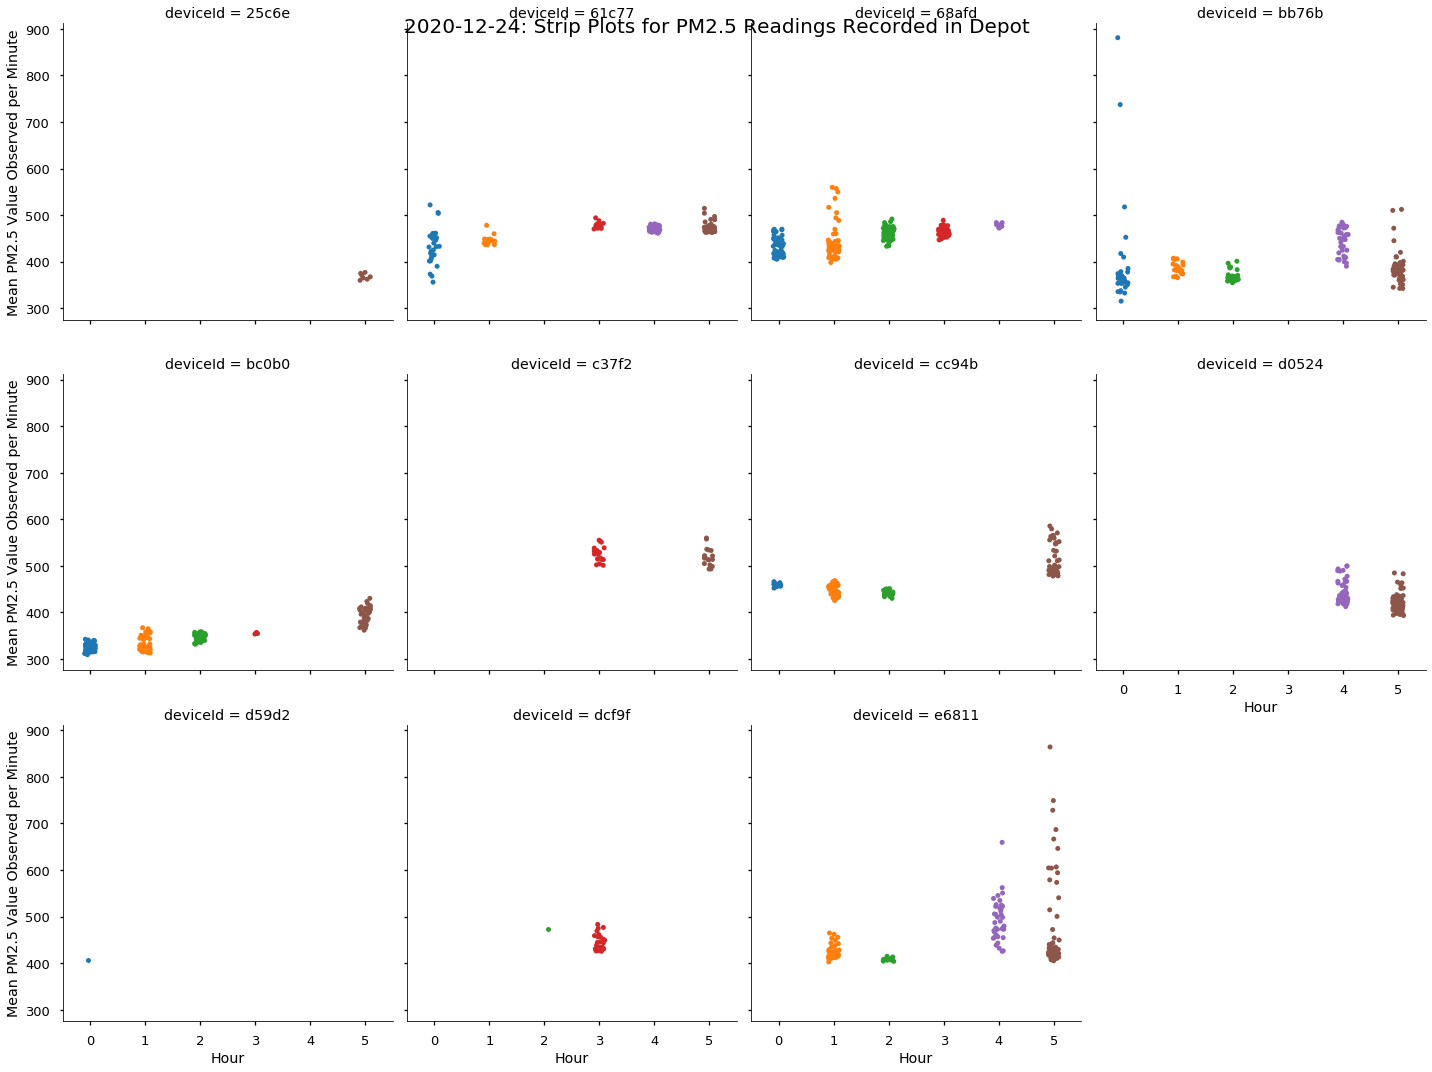

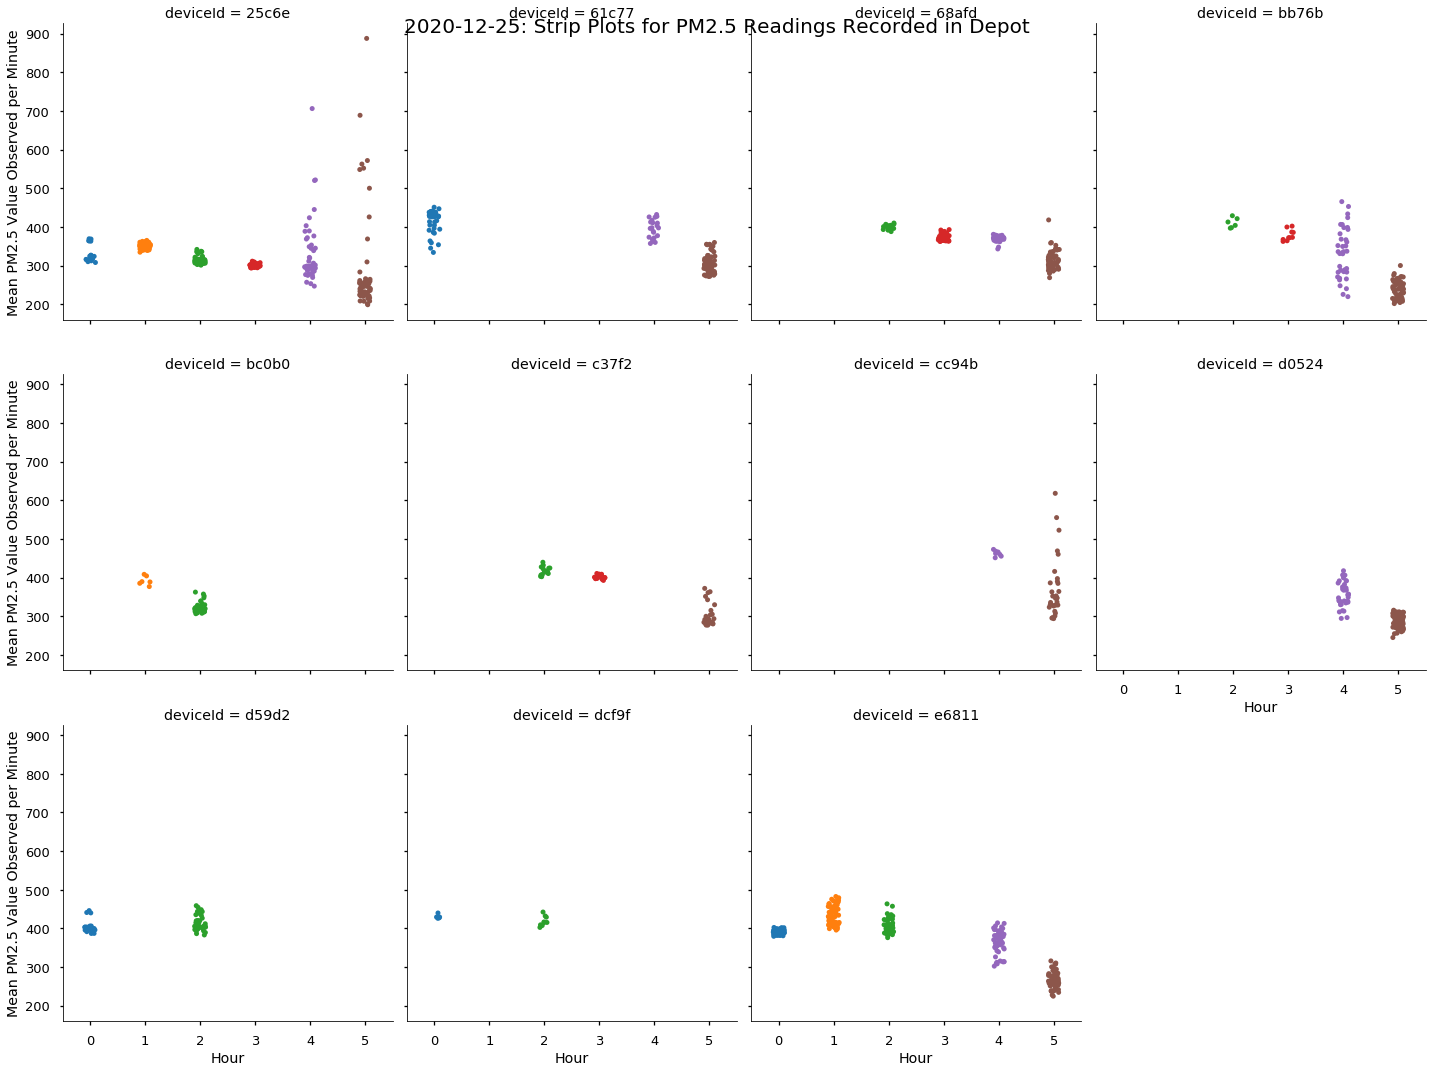

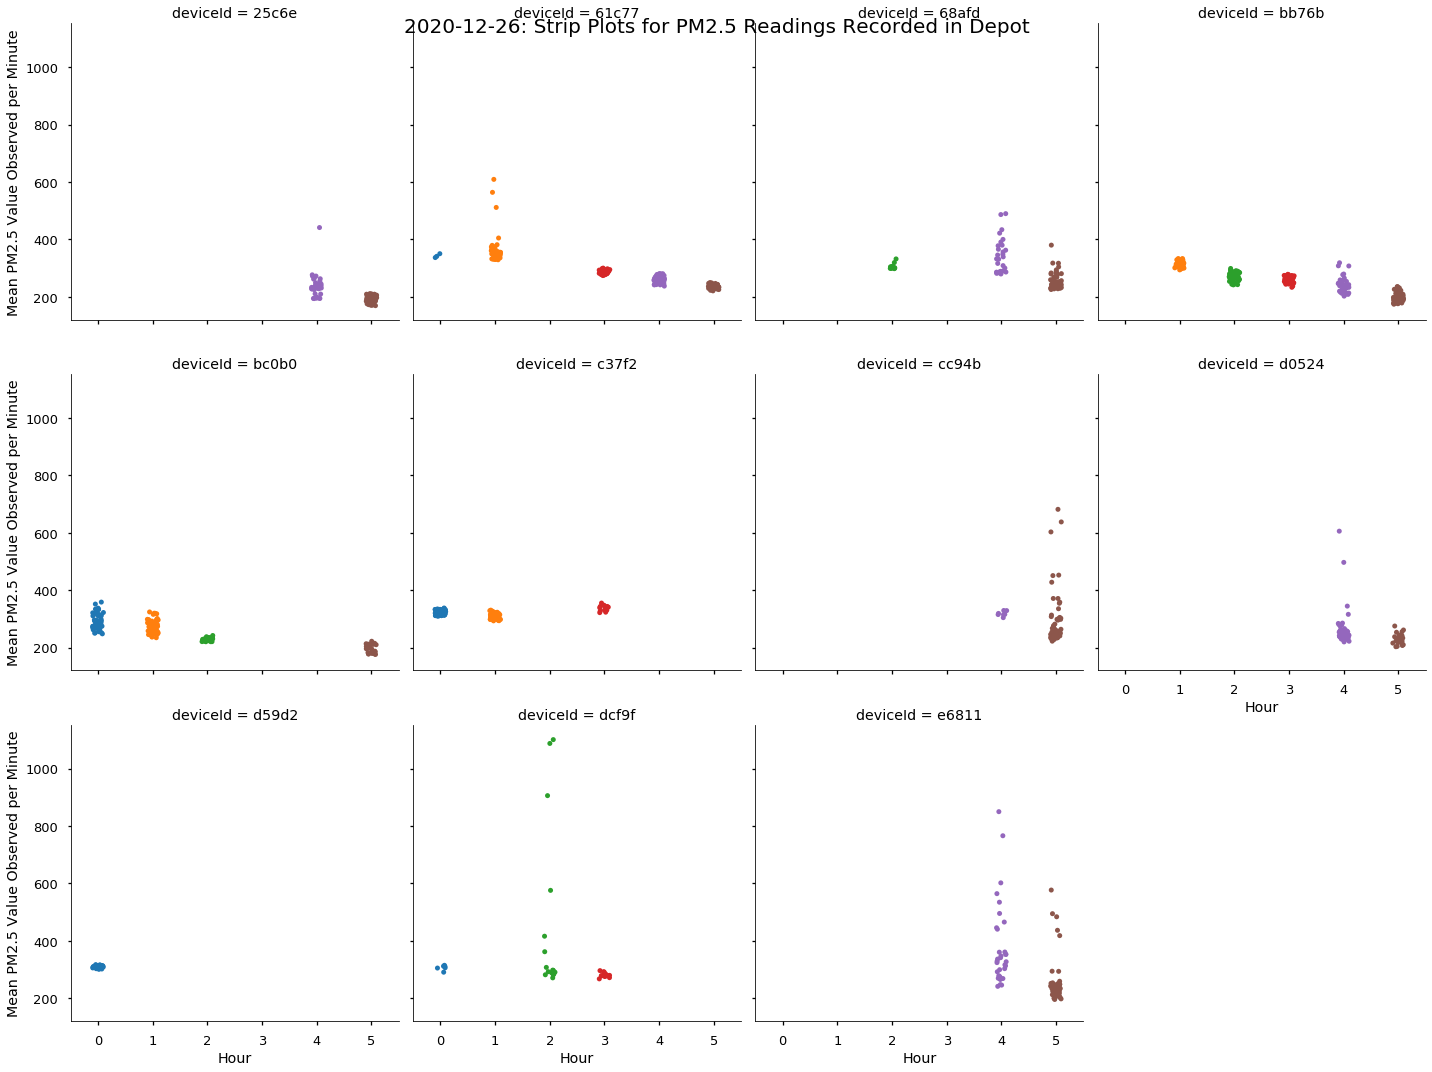

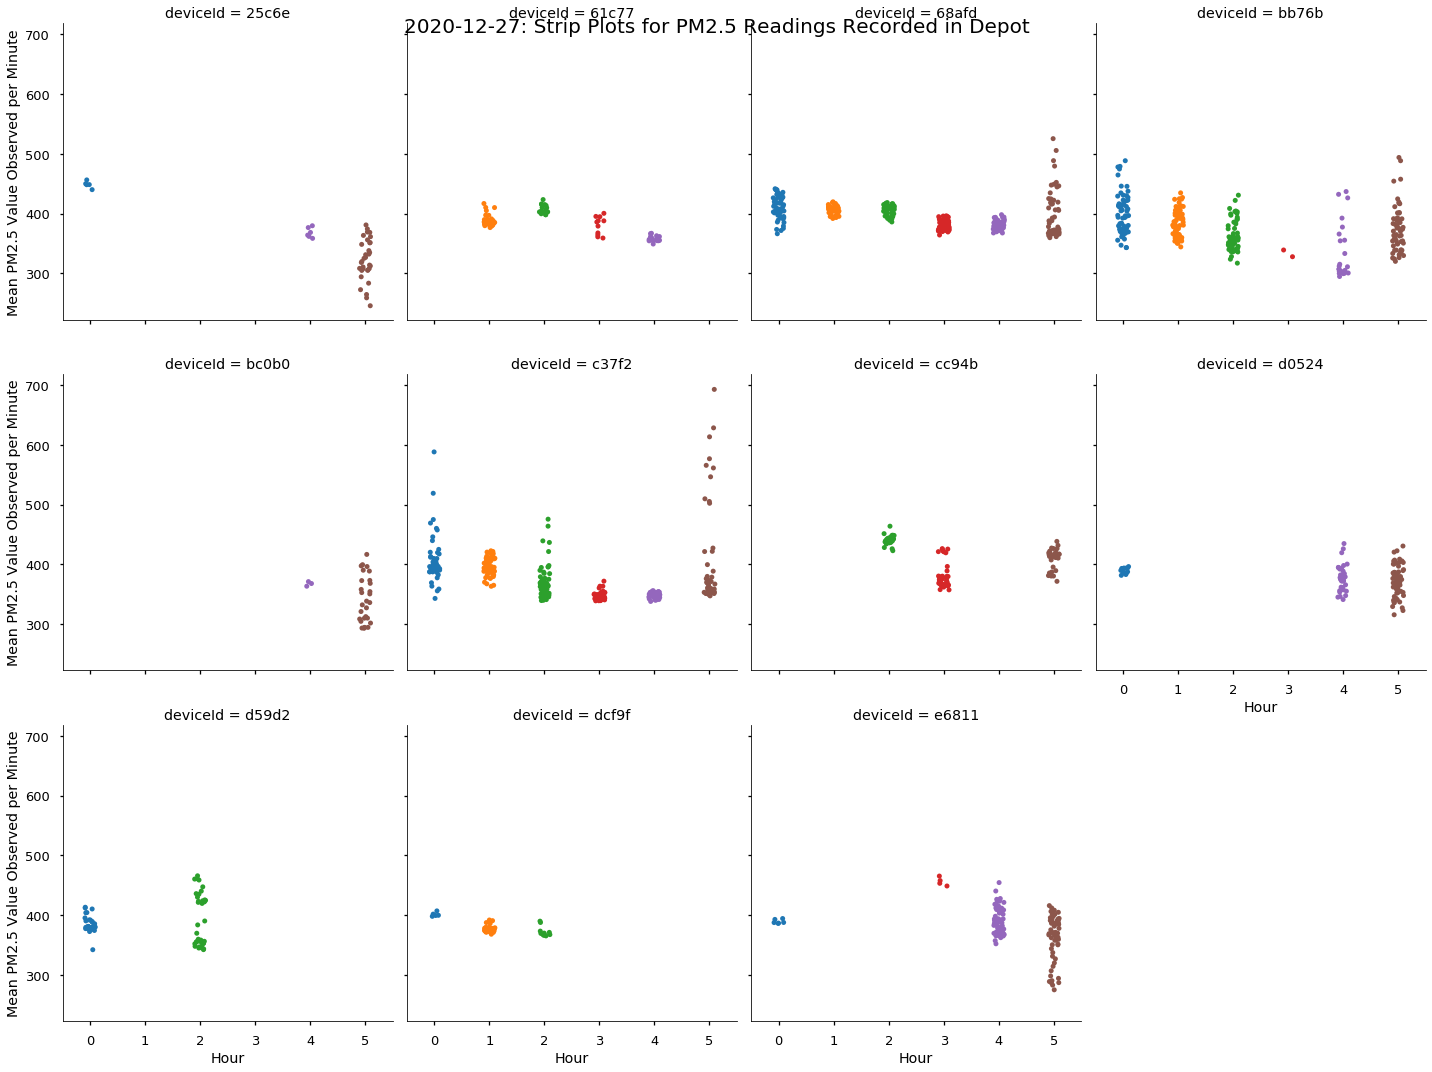

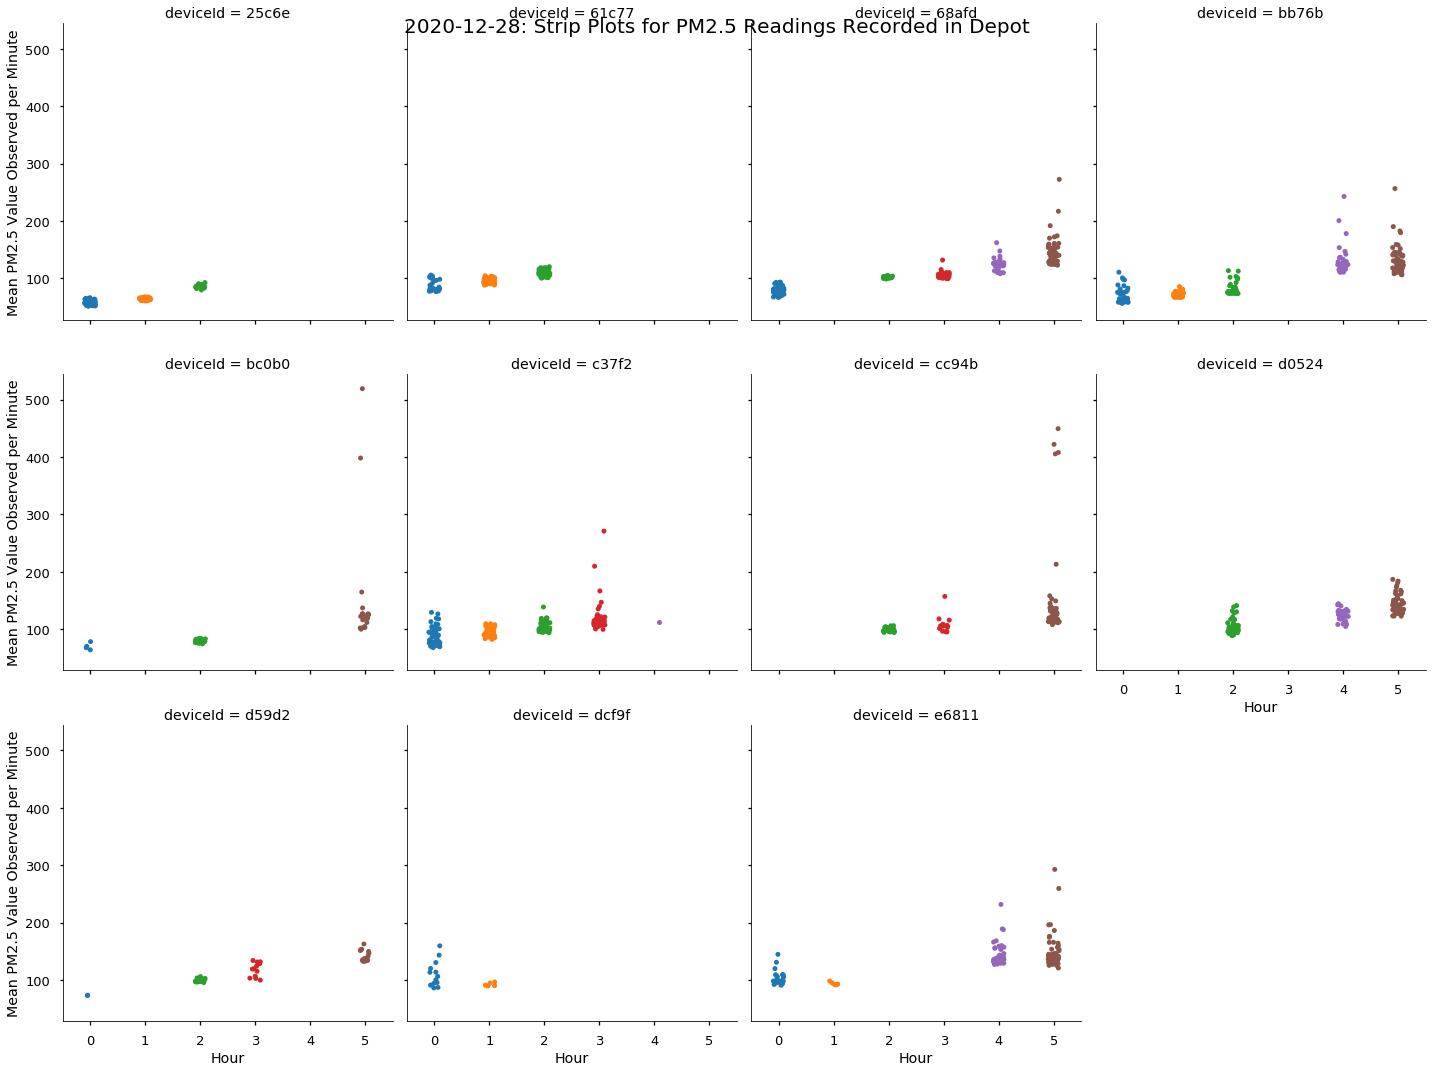

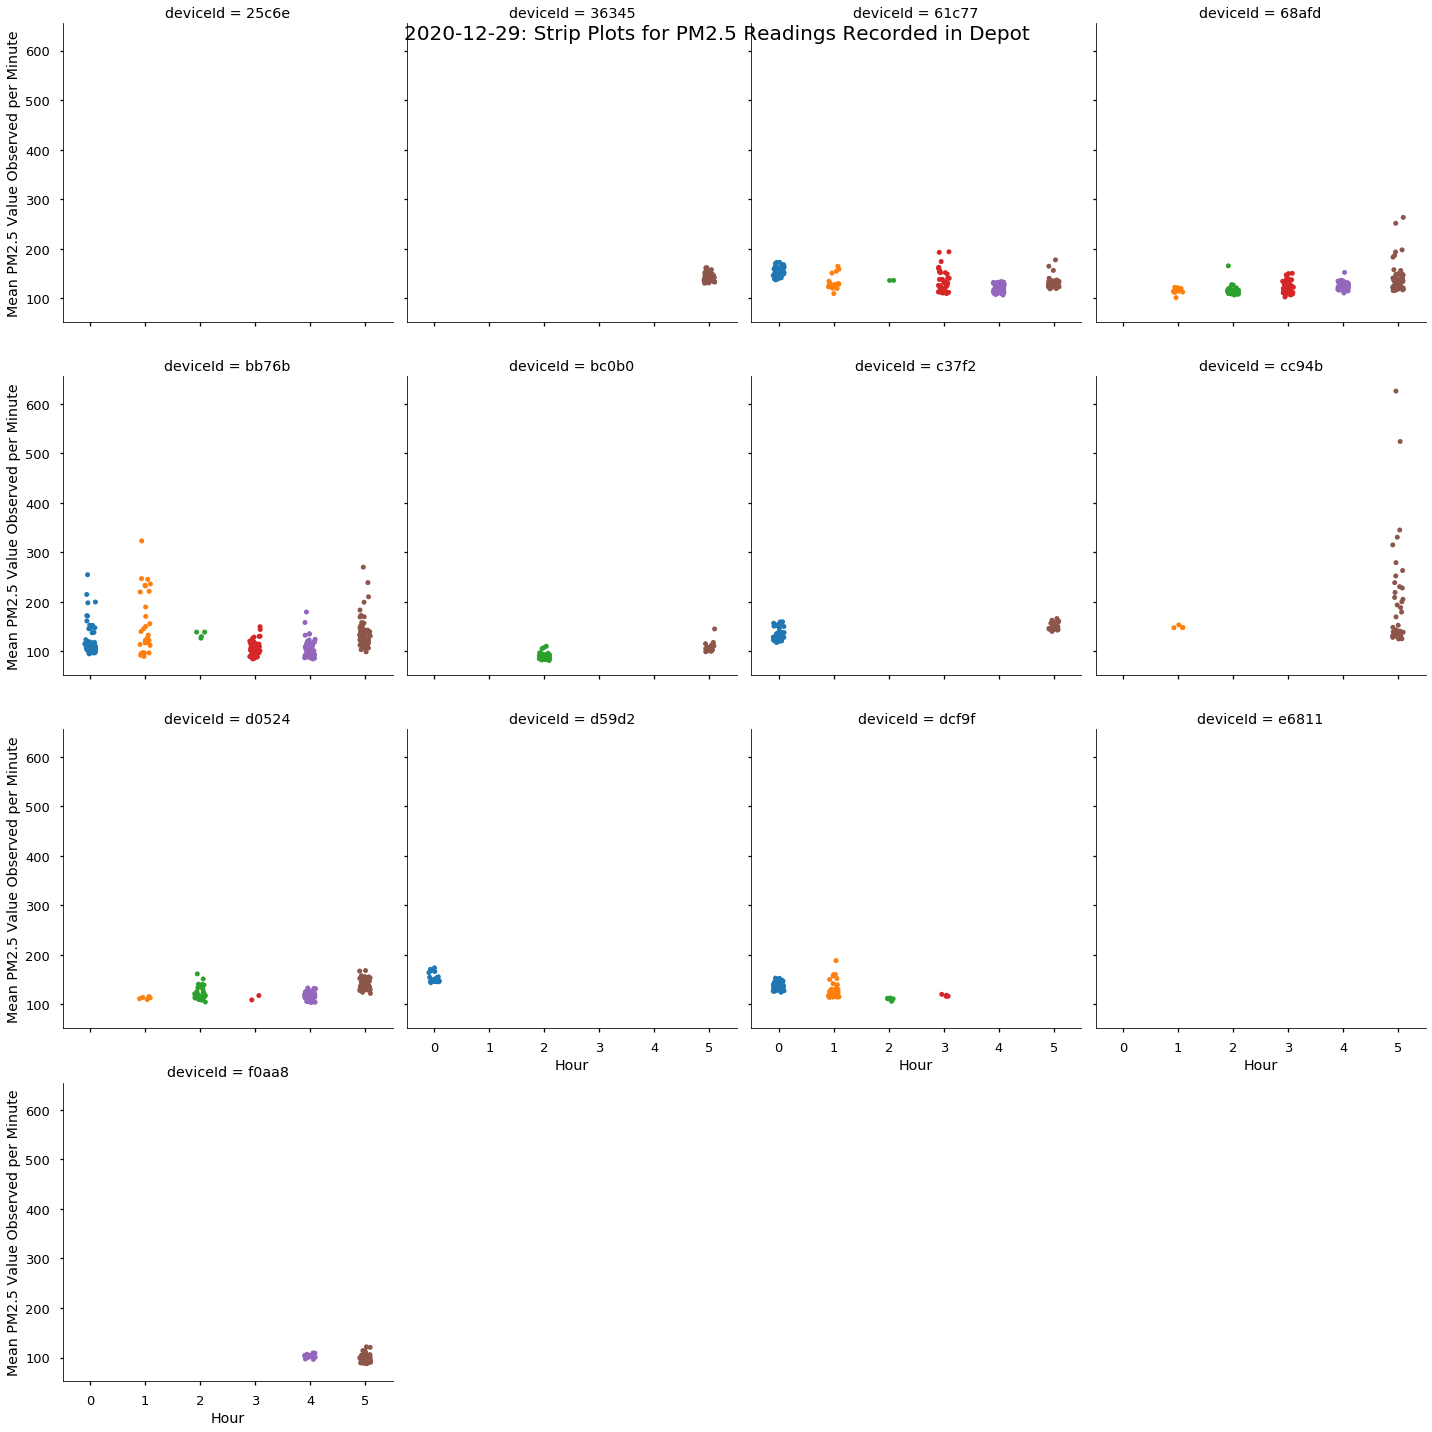

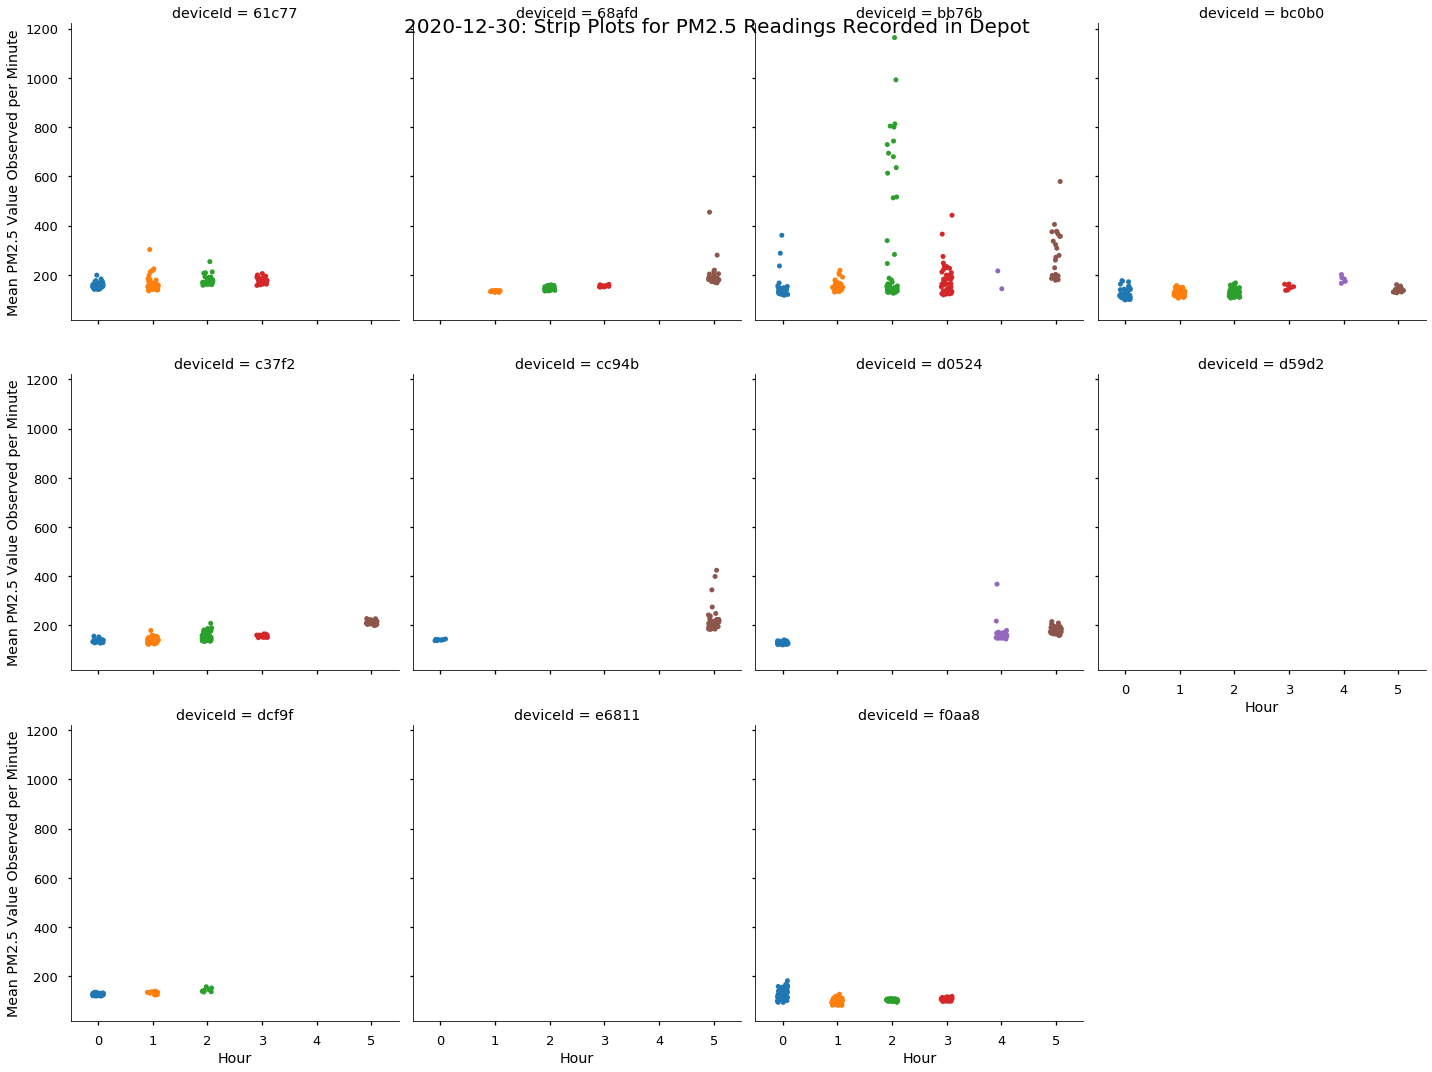

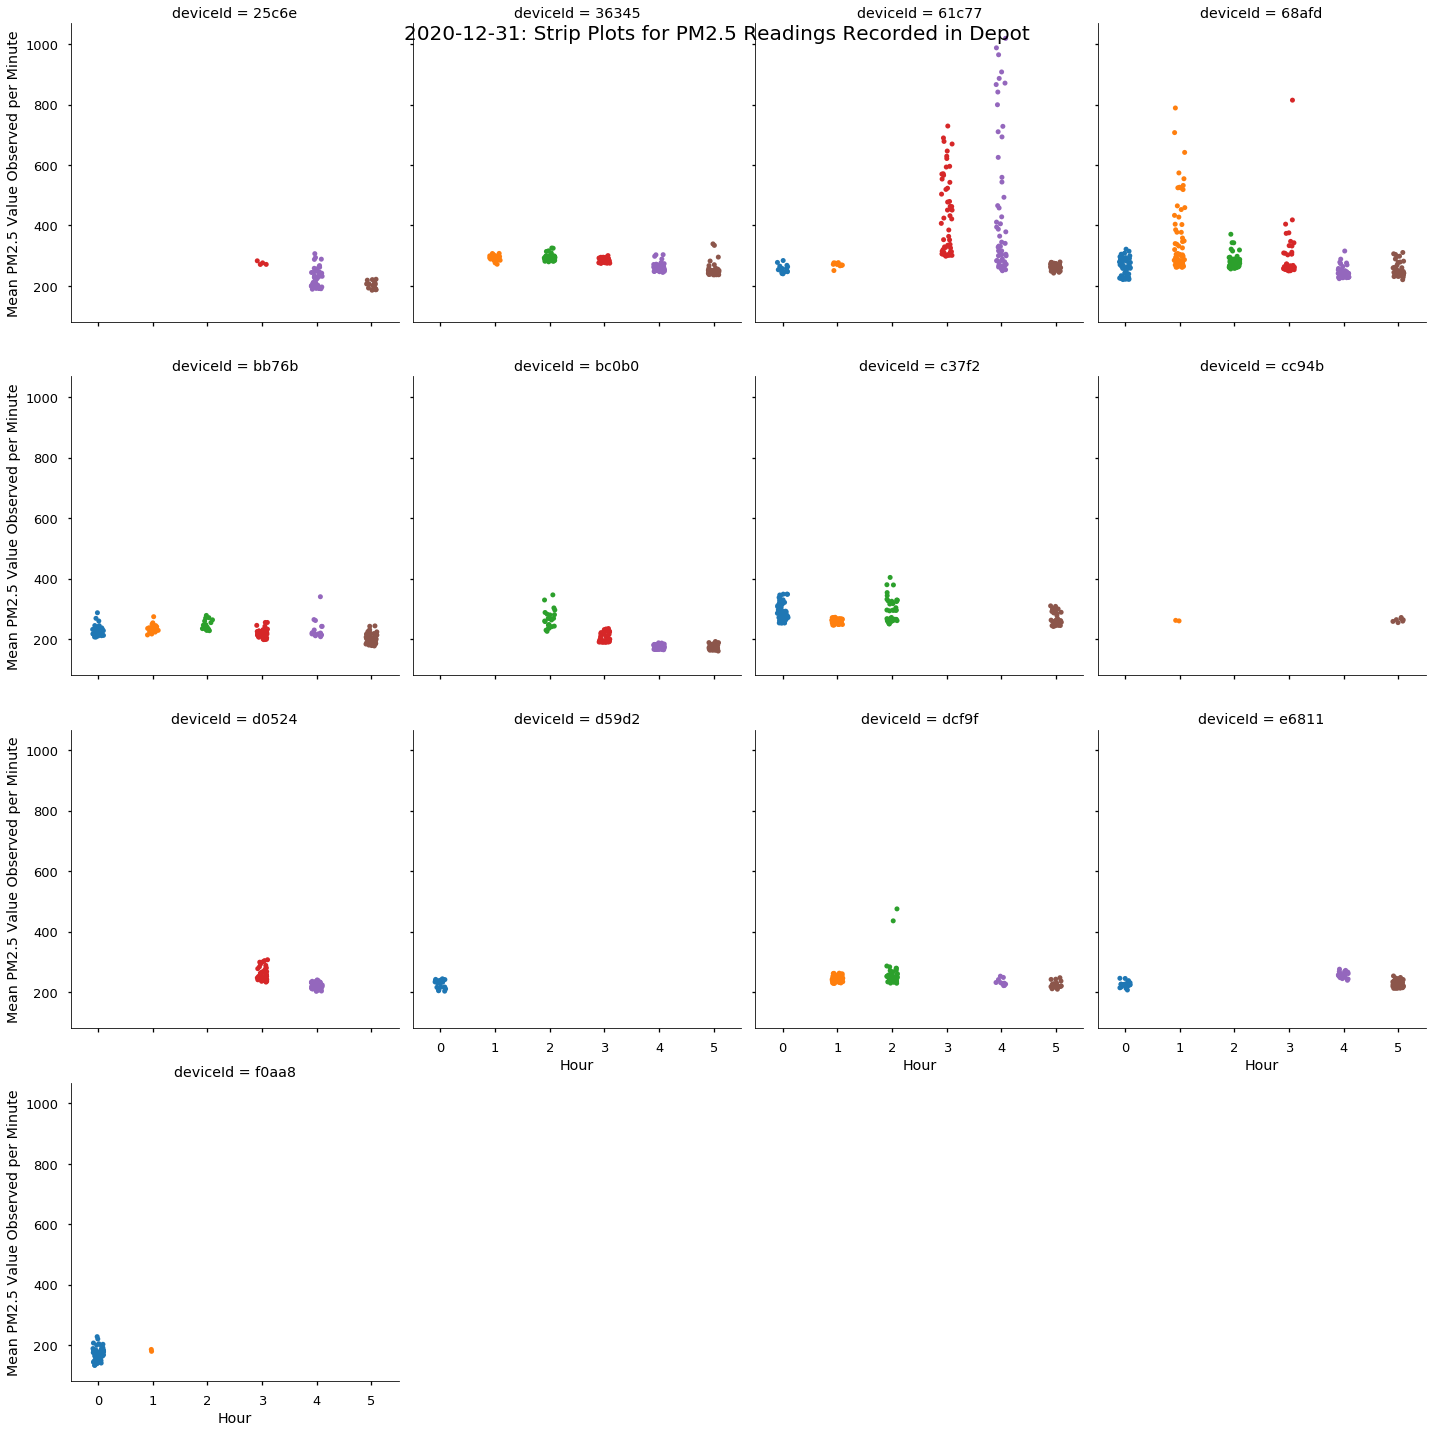

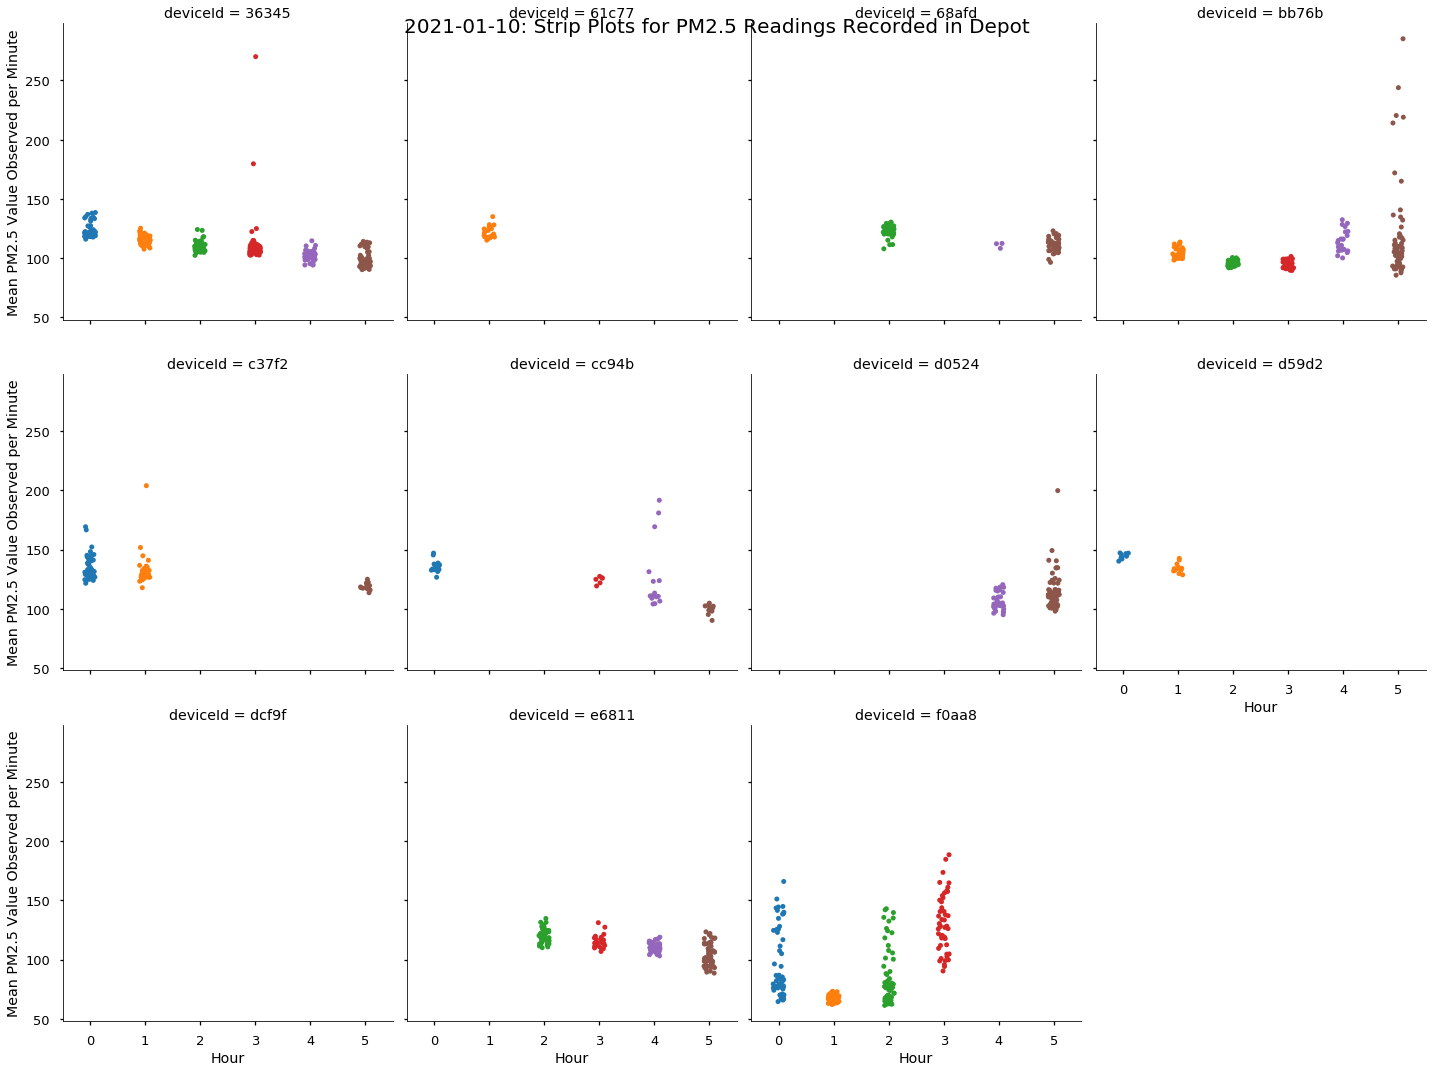

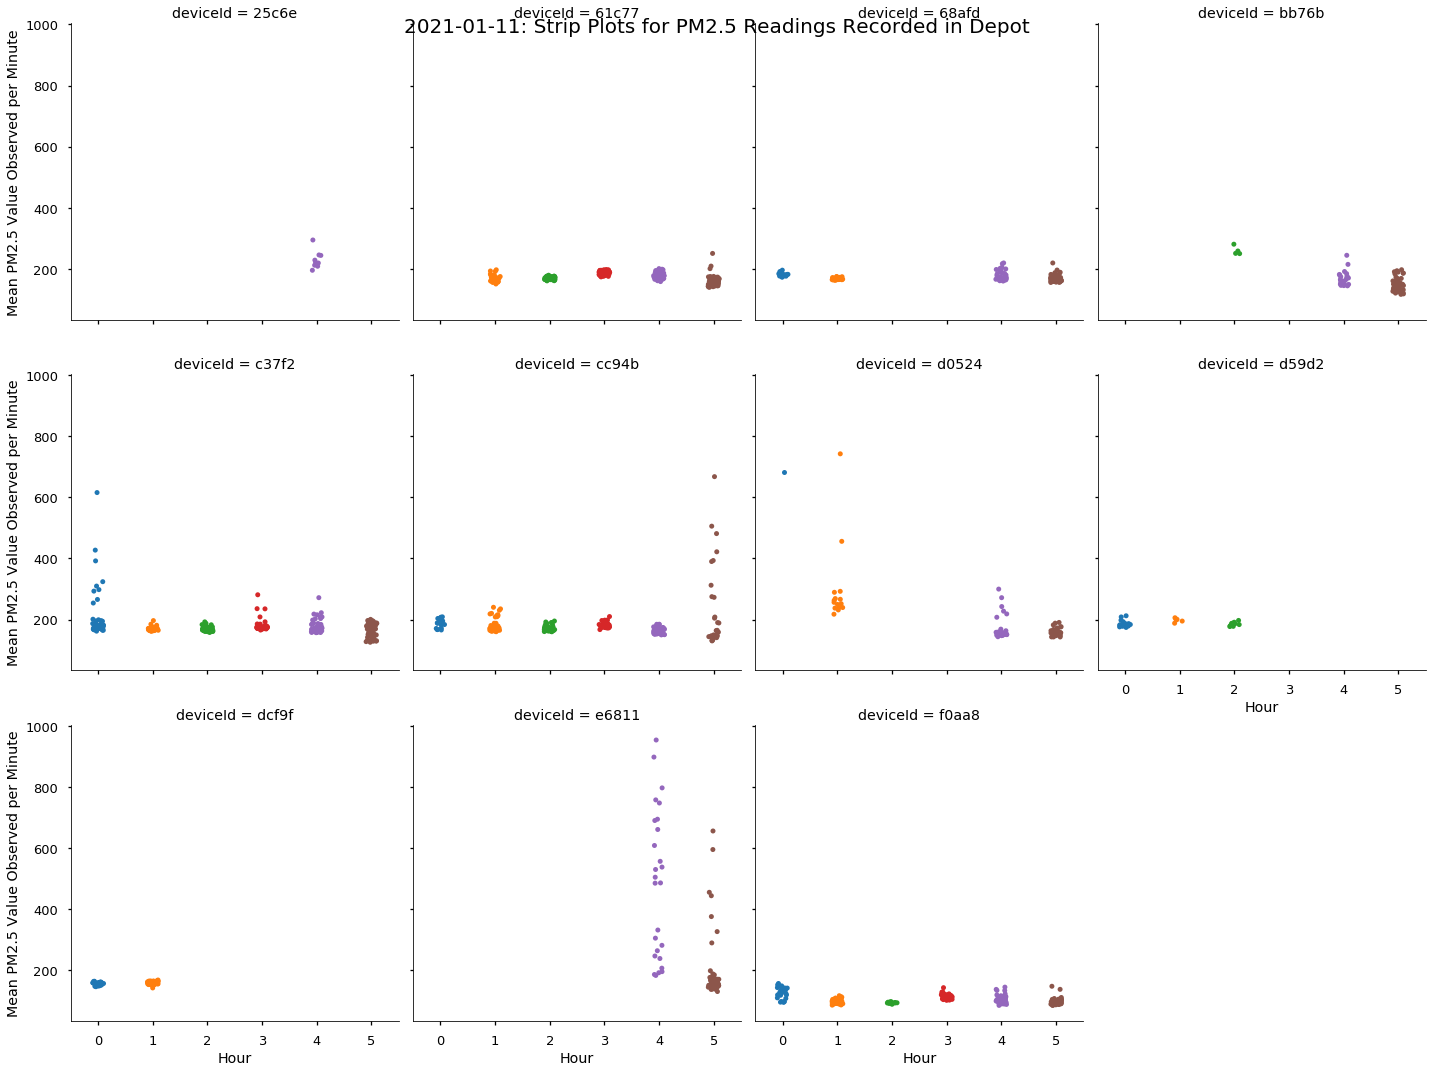

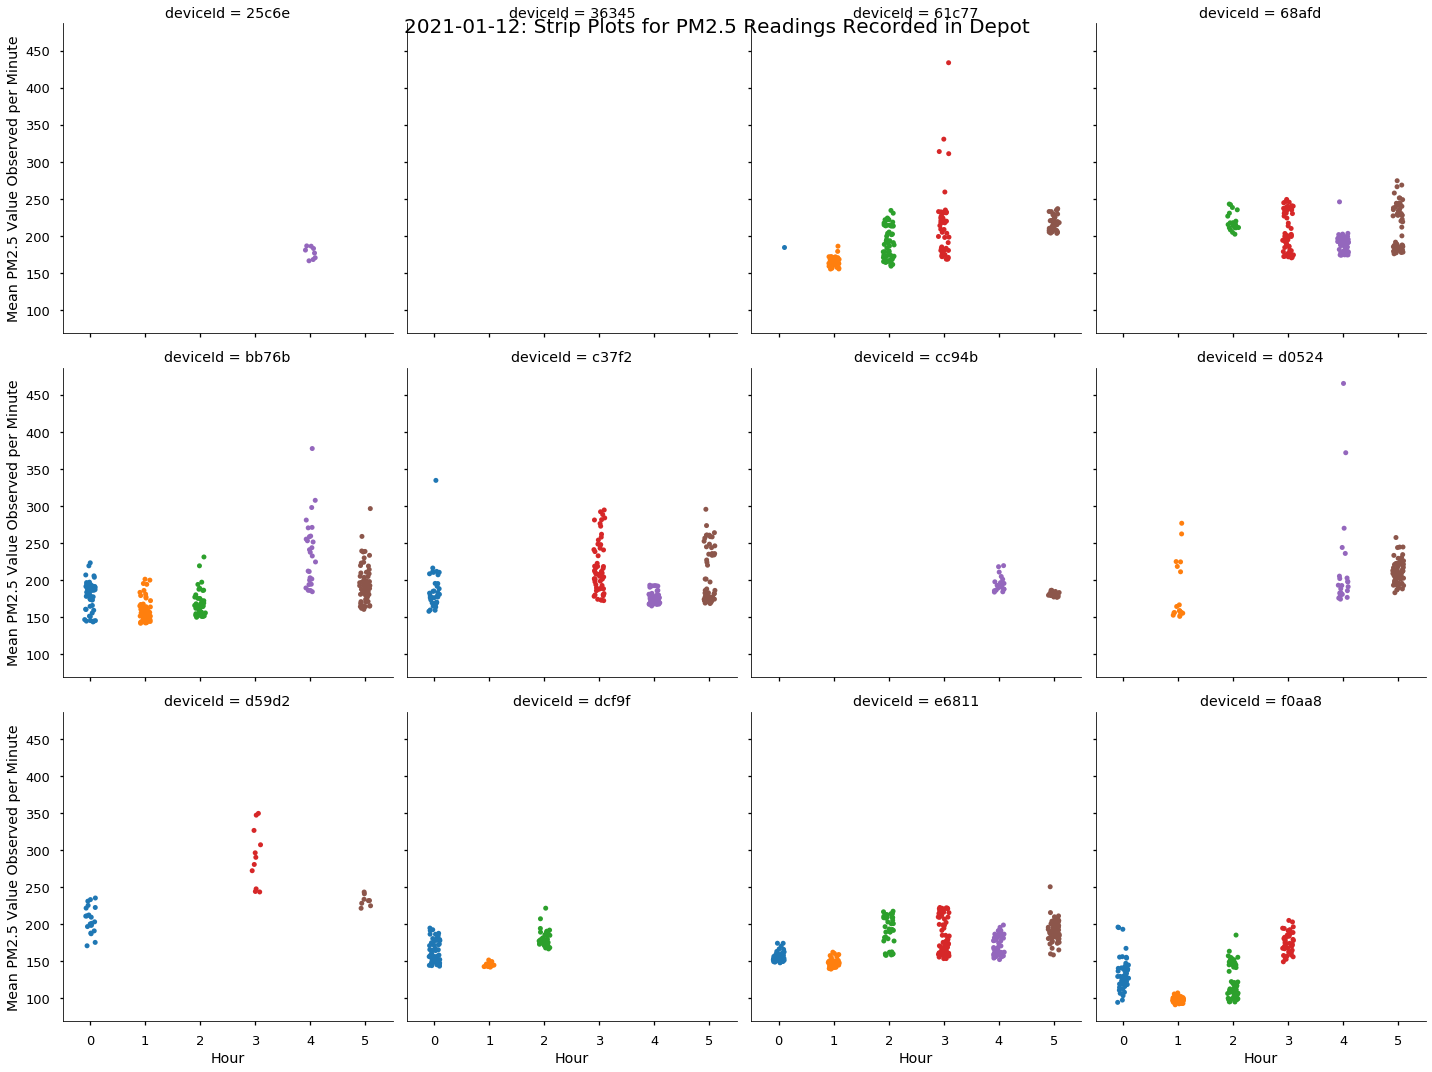

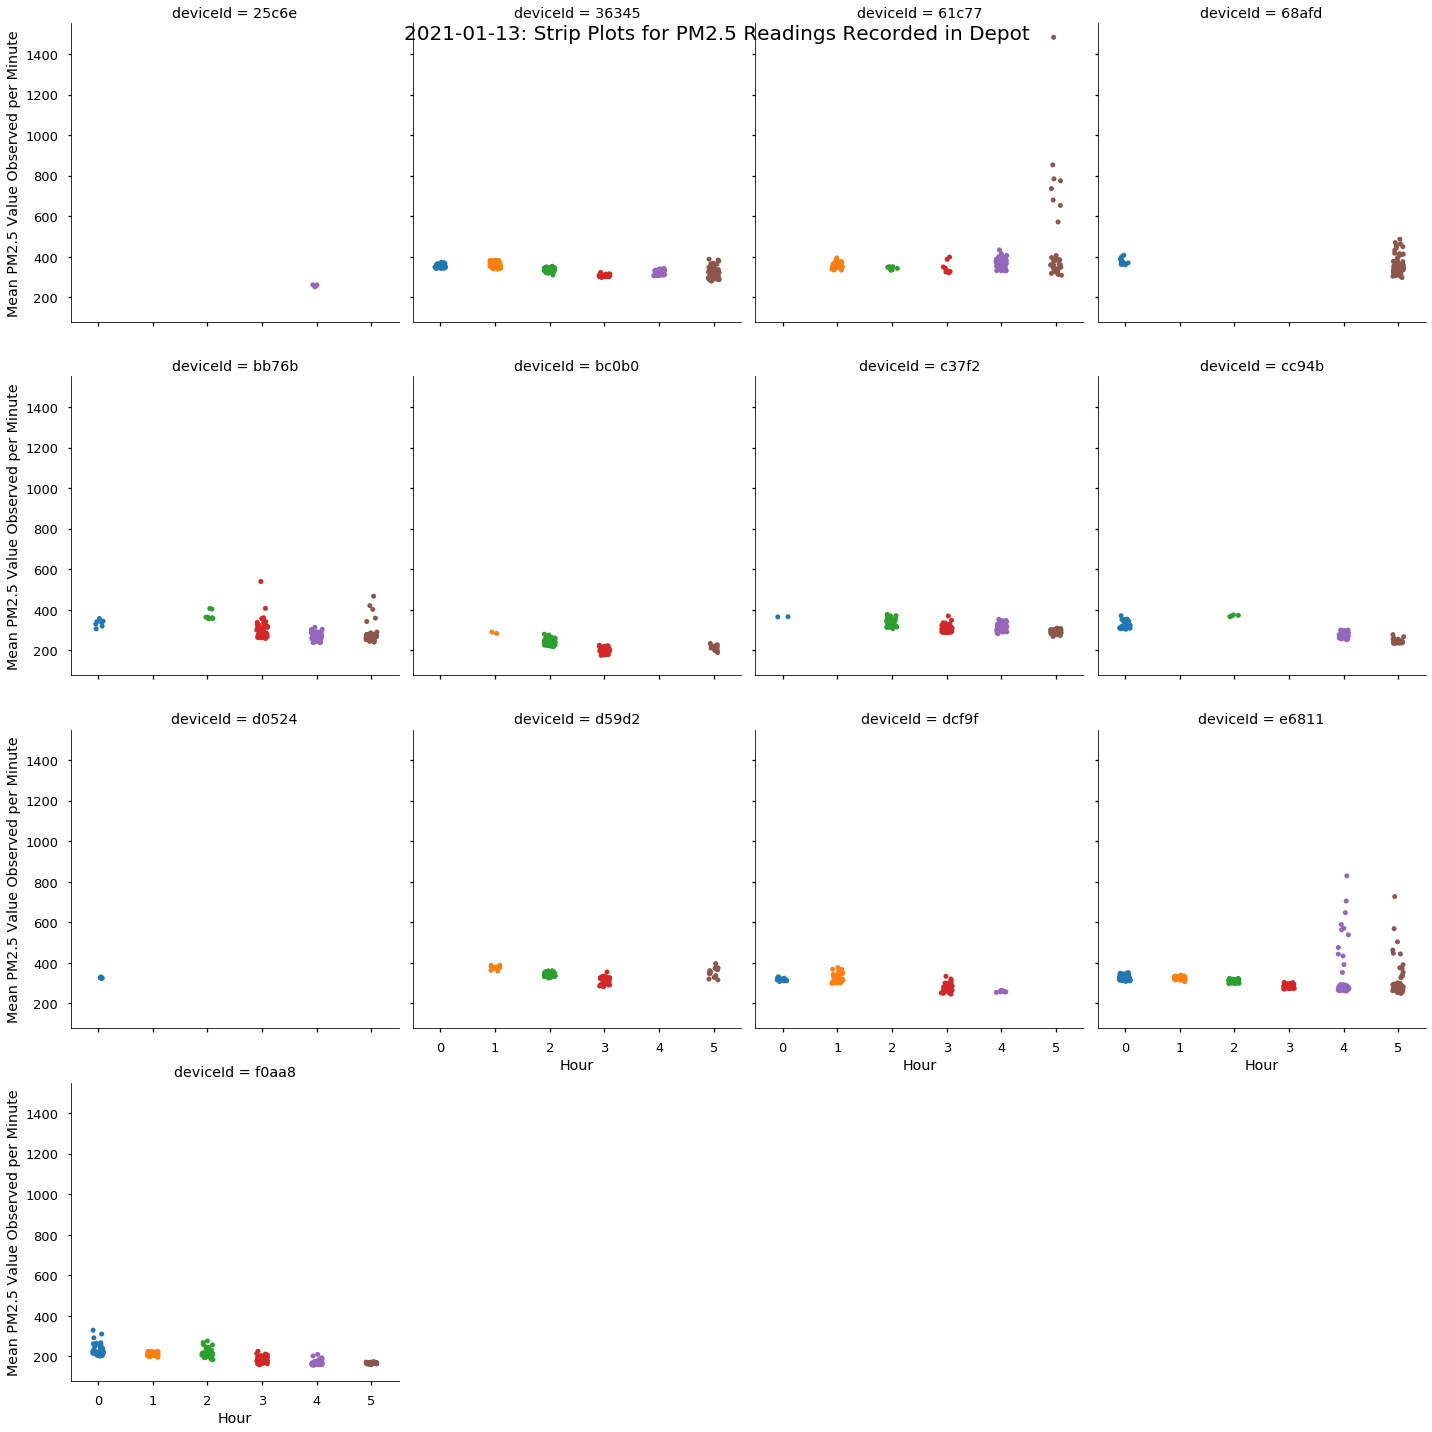

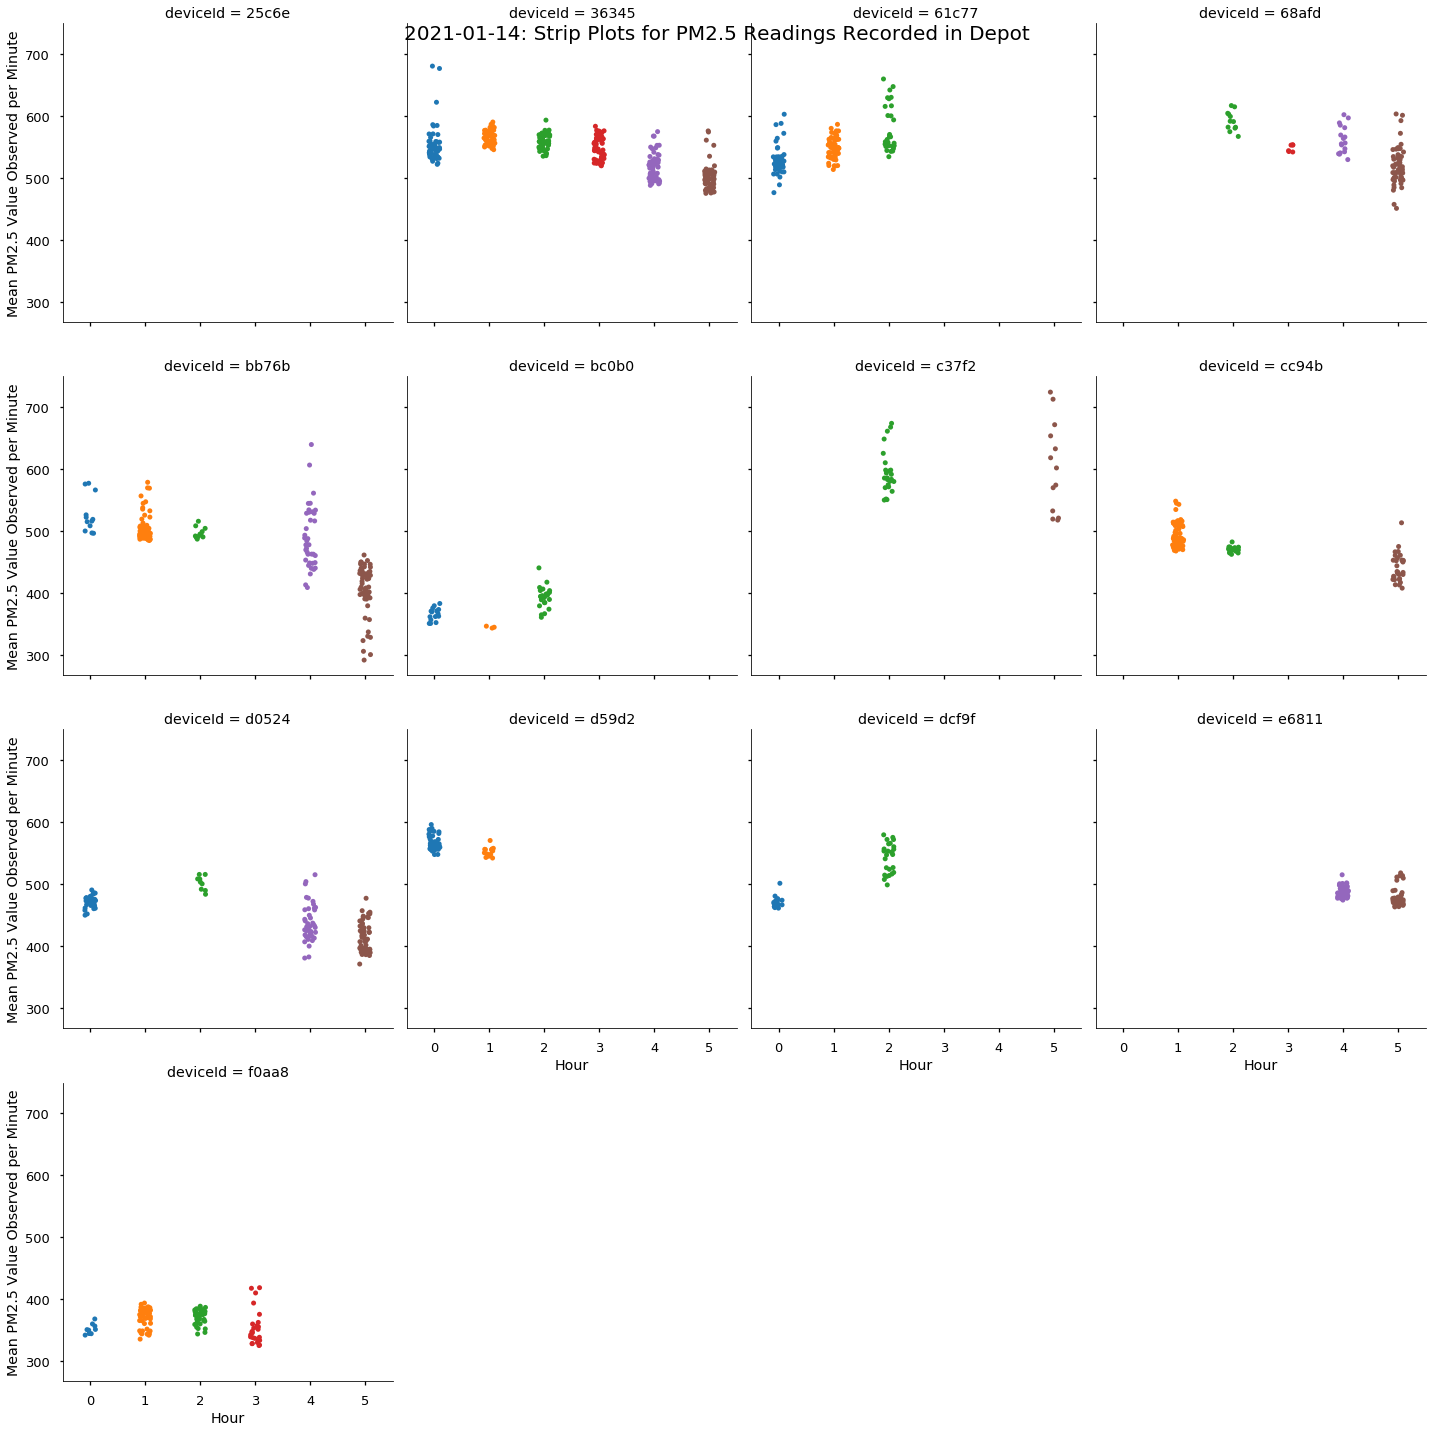

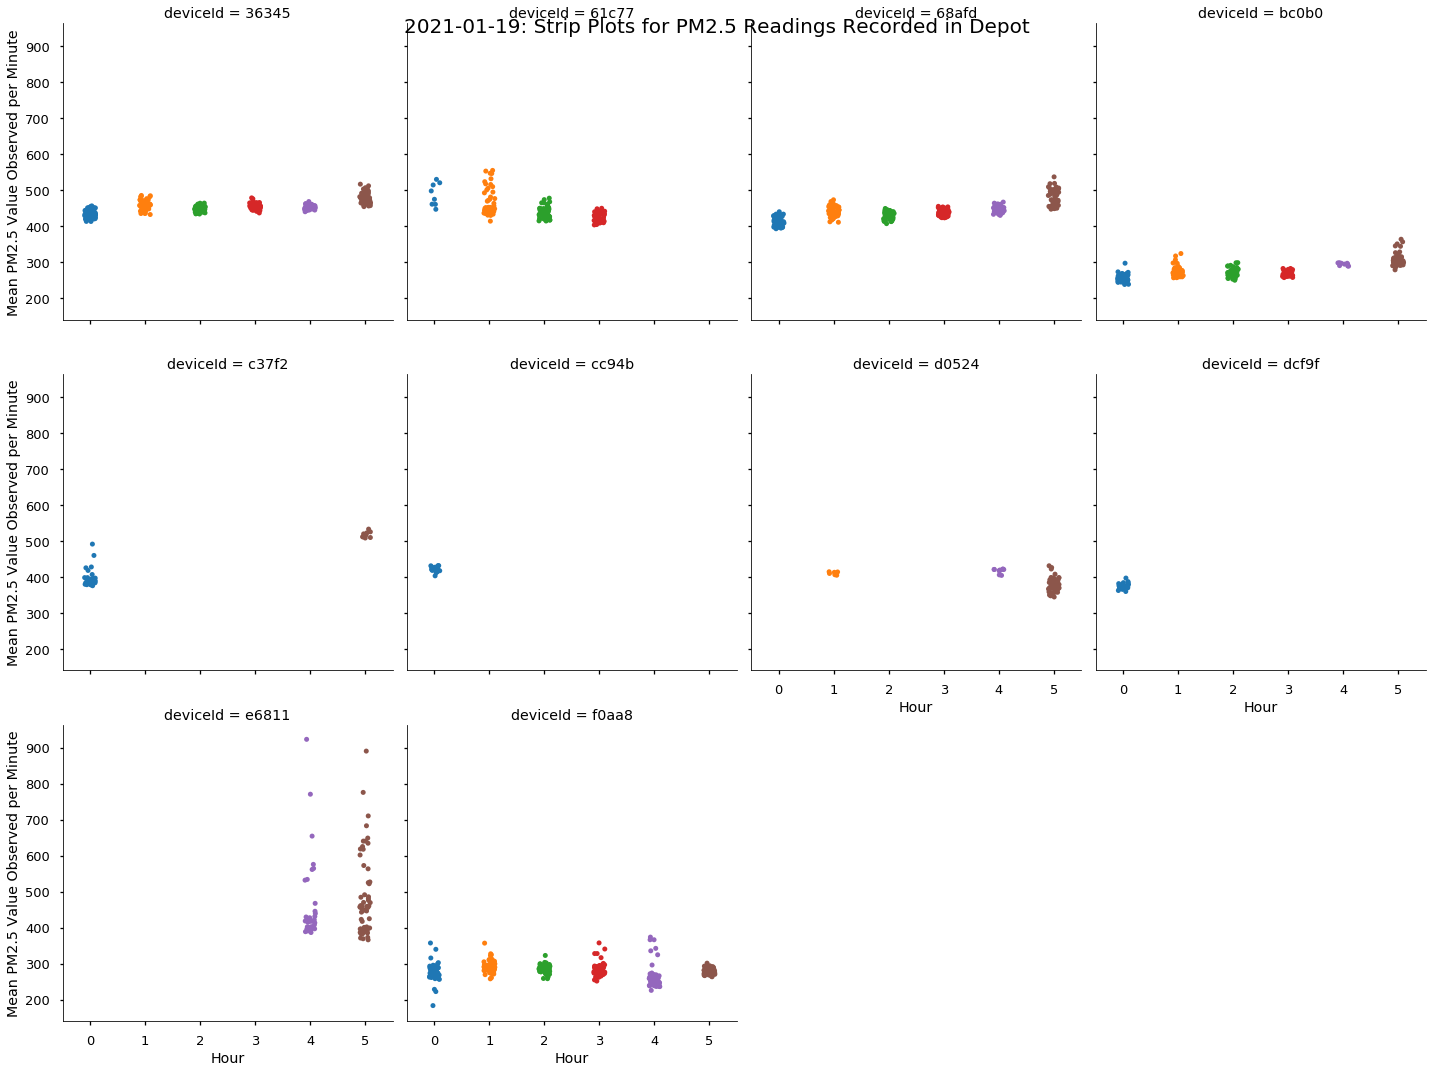

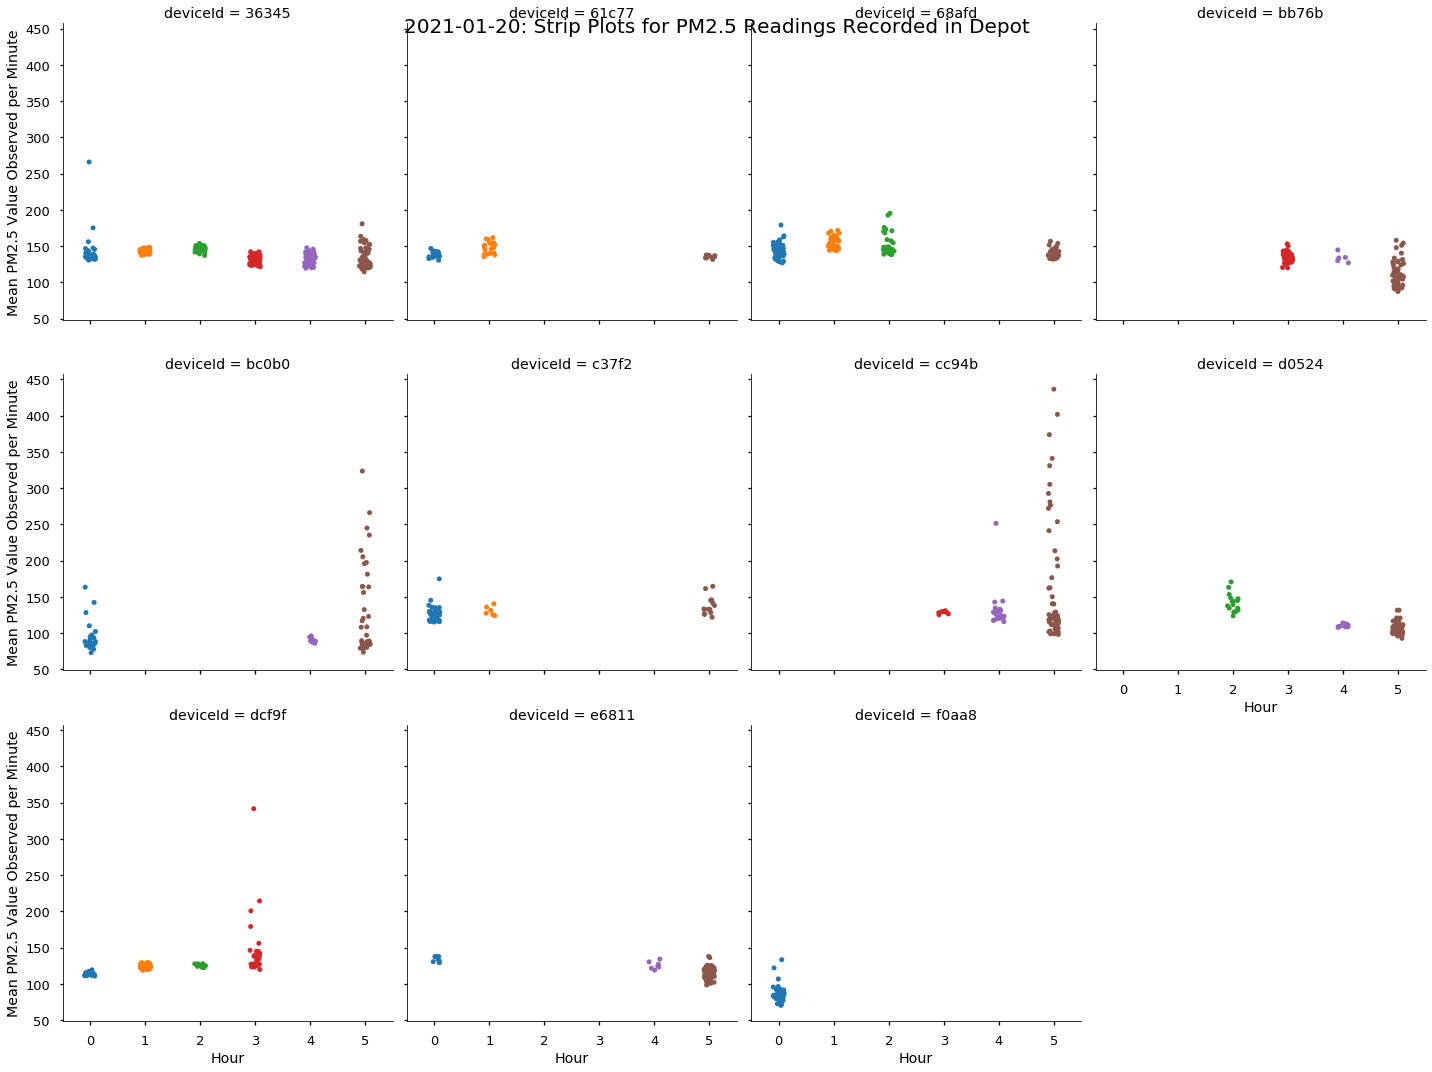

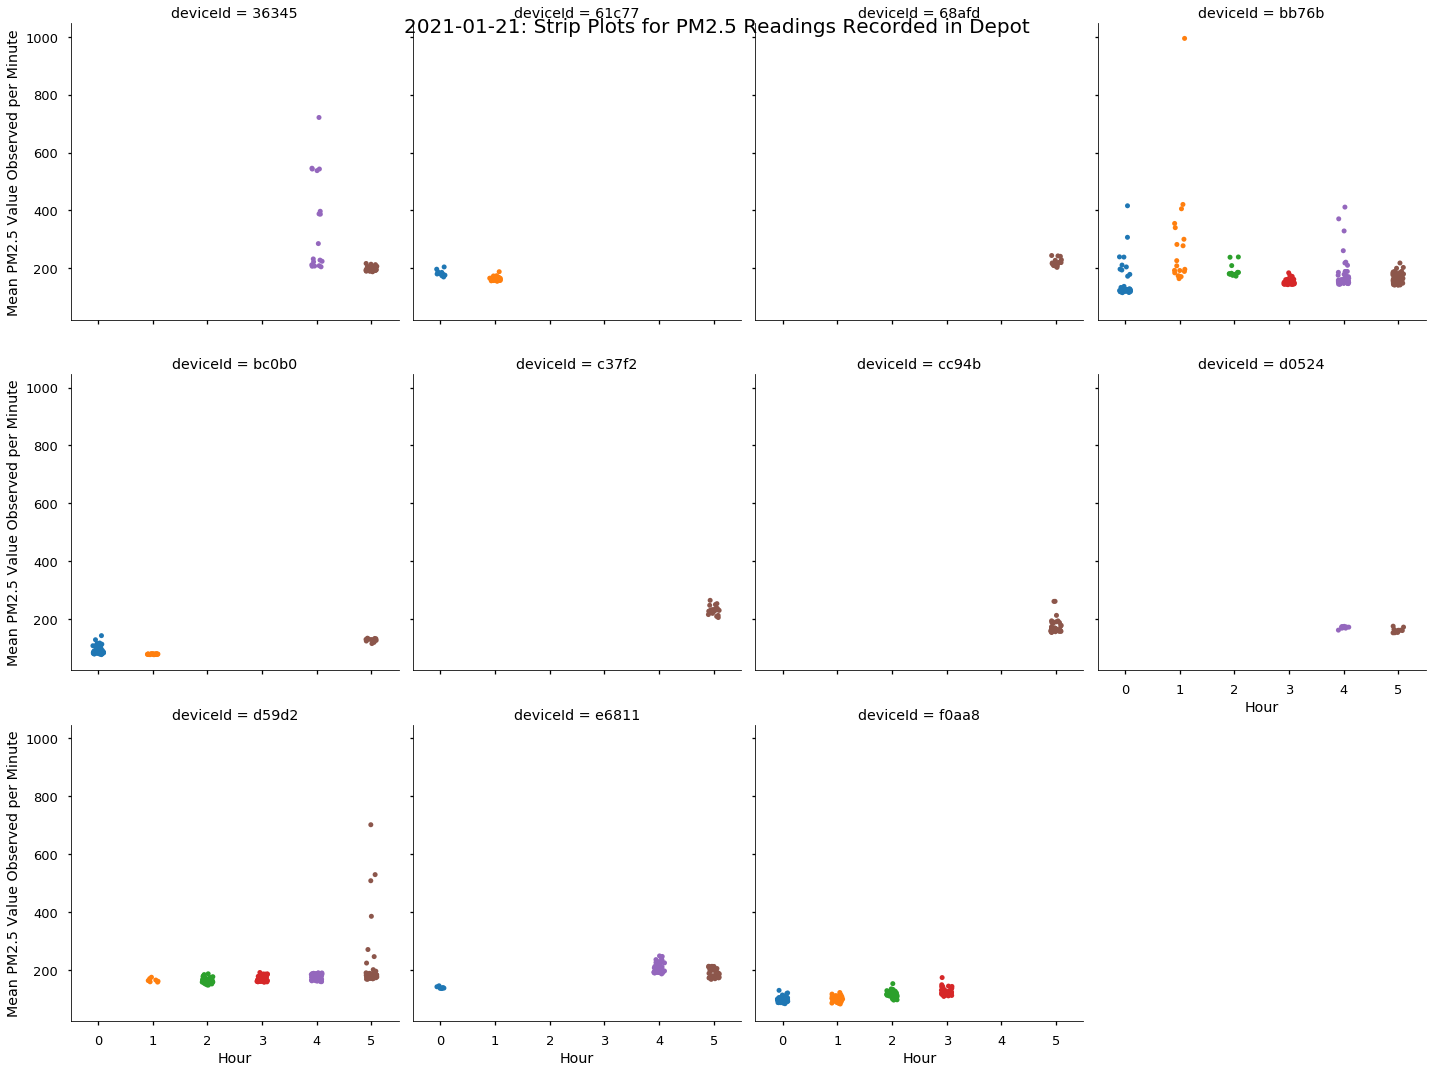

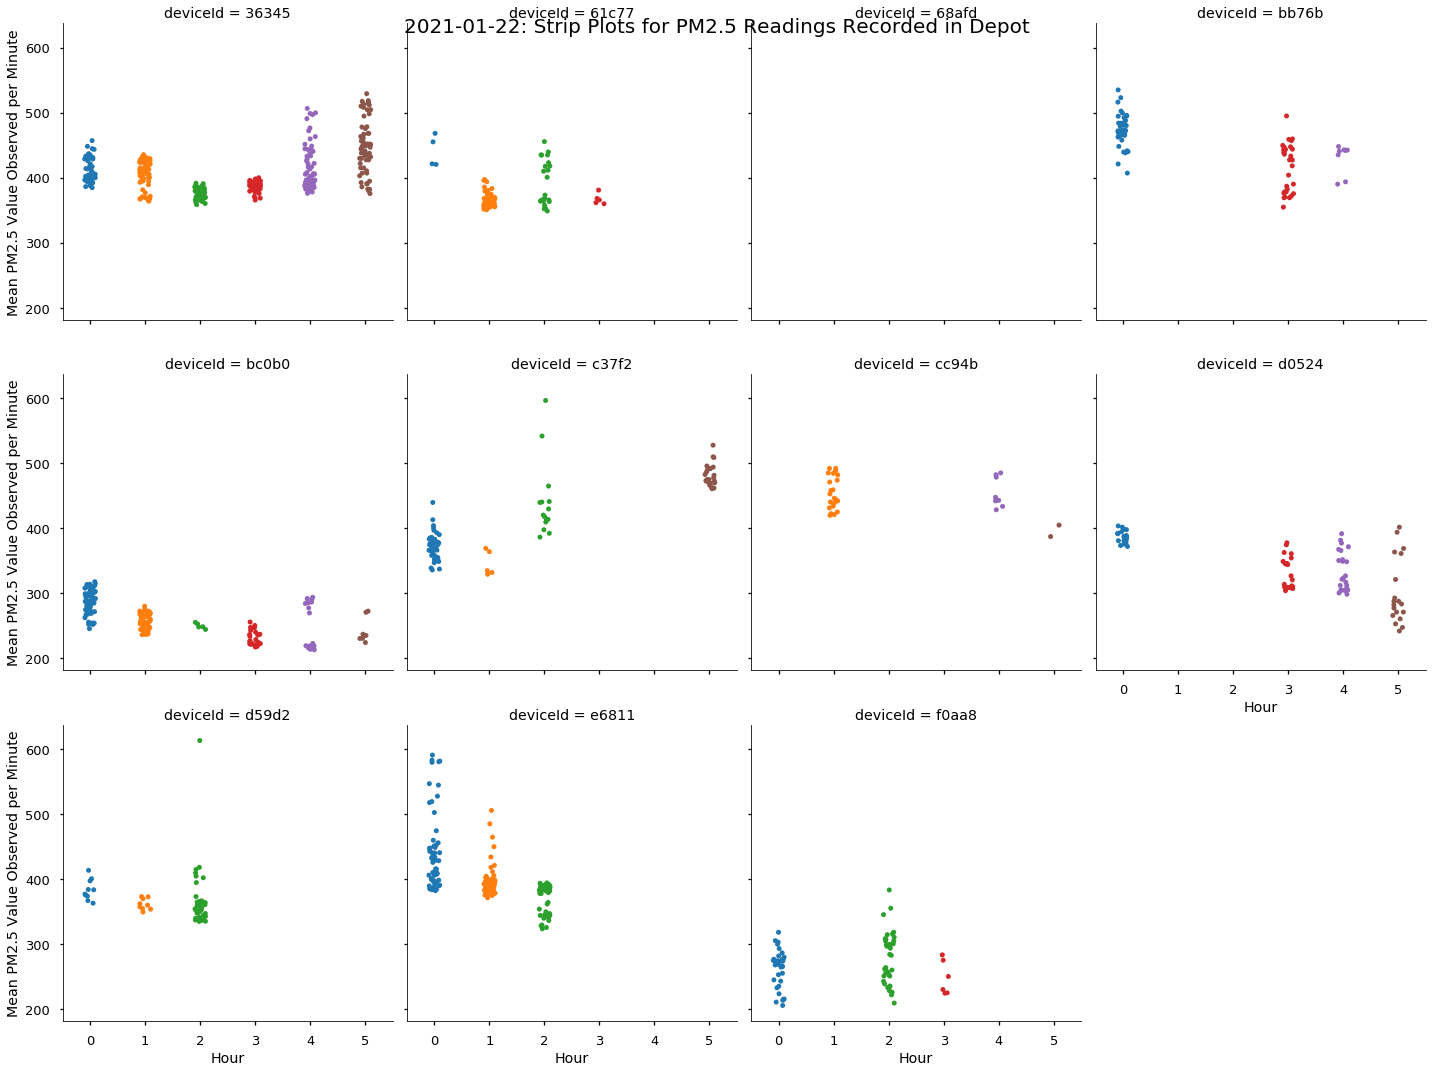

PermissionError: [Errno 13] Permission denied: '2021-01-8_inter_sensor.pdf'

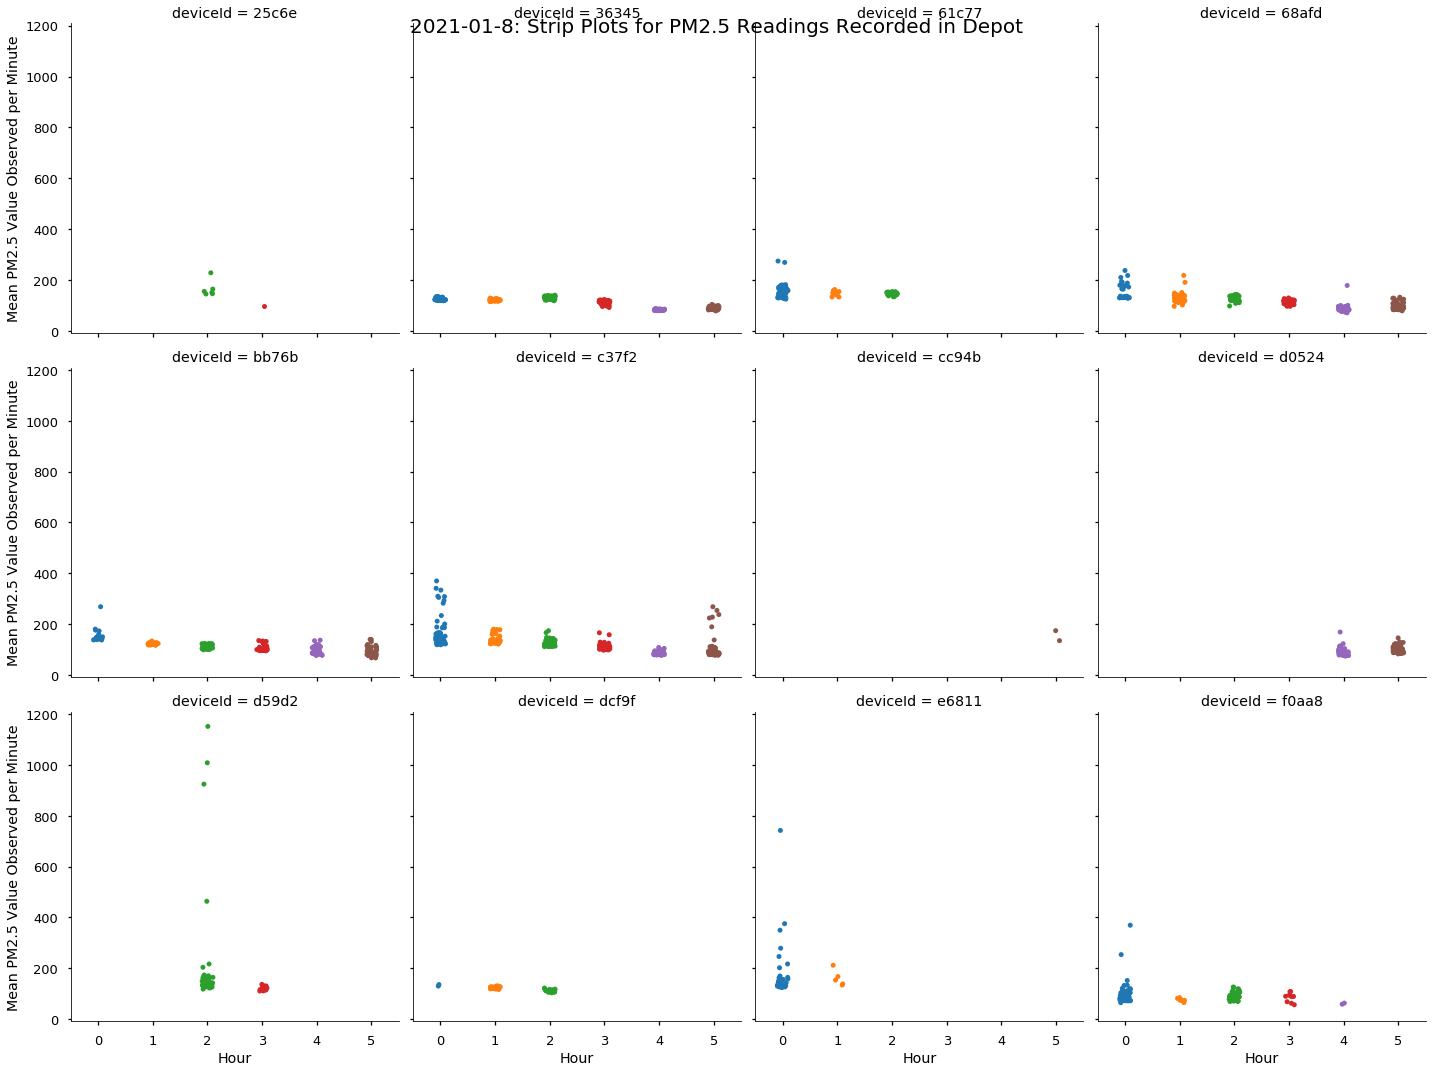

In [50]:
for dt in dates :
    plot_plotwise_for_all_dates_PM25(dt,"pm_1")

2)  Inter-Sensor Distribution of PM 2.5  Values at Depot

In [ ]:
plot_plotwise("pm_2")

-----

# Leave The Below

### Sanity Check: SPC

In [ ]:
ds_means = np.empty((1,4))
ds_means = pd.DataFrame(ds_means, columns= ["date", "deviceId", "mean", "std"])

for day_int in range(13, 15):
    dt = "2020-11-" + str(day_int)
    print(dt)
    df_bme, df_gps, df_pol = read_raw(dt)
    df_all = preprocess((df_bme, df_gps, df_pol))
    
    df_all = df_all[(df_all.hour > 6) & (df_all.hour < 21)]
    
    sensor_order = df_all.deviceId.unique()
    sensor_order.sort()
    
    sampling_rates = df_all.groupby(["deviceId", "hour", "minute"]).size().reset_index()
    metrics = sampling_rates.groupby(["deviceId"]).agg(["mean", "std"])
    
    metrics = metrics[0].reset_index()
    metrics["date"] = dt
    
    ds_means = pd.concat([ds_means, metrics], axis=0)
    print("--*--")
    
ds_means = ds_means.iloc[1:, :]
ds_means.columns = ["date", "deviceid", "means", "deviations"]
ds_means.reset_index(drop = True, inplace= True)

In [ ]:
sns.kdeplot(sampling_rates[0])

In [ ]:
grand_mean = ds_means["means"].mean()

In [ ]:
v1 = sampling_rates[sampling_rates.deviceId == sensor_order[0]][0].values
v2 = sampling_rates[sampling_rates.deviceId == sensor_order[6]][0].values
print(sensor_order[0], sensor_order[6])

In [ ]:
se = ds_means["deviations"].mean()/0.9896

In [ ]:
ucl = grand_mean + 3*se/24
lcl = grand_mean - 3*se/24

In [ ]:
ds_means["means"].plot(style= "o")
plt.hlines(y =ucl , xmin = 0 , xmax = ds_means.shape[0], linestyles = "--")
plt.hlines(y =lcl , xmin = 0 , xmax = ds_means.shape[0], linestyles = "--")
plt.hlines(y =grand_mean , xmin = 0 , xmax = ds_means.shape[0])
plt.title("Control Charts")
plt.xlabel("Sample Number")
plt.ylabel("Sampling per hour Rate")

In [ ]:
from scipy.stats import ttest_ind

from scipy.stats import shapiro
from scipy.stats import mannwhitneyu
from scipy.stats import epps_singleton_2samp

In [ ]:
epps_singleton_2samp(v1, v1)

In [ ]:
mannwhitneyu(v1, v1 + 0.00000000000000000005)

In [ ]:
shapiro(v2)

In [ ]:
ttest_ind(v1, v2)